In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.optimizer_v2.adam import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

In [5]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### Load Data

In [6]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [7]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'
filename_B1 = 'AC/AC_all.hdf5'
filename_B2 = 'CNNS/CNNS_all.hdf5'
filename_B3 = 'RN/RN_all.hdf5'
filename_B4 = 'WALL/WALL_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [8]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_B1 = h5py.File(filefolder+filename_B1,'r')
f_B2 = h5py.File(filefolder+filename_B2,'r')
f_B3 = h5py.File(filefolder+filename_B3,'r')
f_B4 = h5py.File(filefolder+filename_B4,'r')

f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [9]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 15000


NUM_DAT_AC = round(num_data*f_AC)
NUM_DAT_CNNS = max(2, round(num_data*f_CNNS))
NUM_DAT_RN = round(num_data*f_RN)
NUM_DAT_WALL = round(num_data*f_WALL)

NUM_DAT_ER = num_data - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

In [10]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_B1 = 0
max_pS1_B2 = 0
max_pS1_B3 = 0
max_pS1_B4 = 0

max_pS1_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS1_B1 = max(max_pS1_B1, len( f_B1['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS1_B2 = max(max_pS1_B2, len( f_B2['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS1_B3 = max(max_pS1_B3, len( f_B3['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL+1):
    max_pS1_B4 = max(max_pS1_B4, len( f_B4['peakS1_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_B1,max_pS1_B2,max_pS1_B3,max_pS1_B4,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_B1 = np.pad(f_B1['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B1), 'constant')
peakS1_onlyhits_B2 = np.pad(f_B2['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B2), 'constant')
peakS1_onlyhits_B3 = np.pad(f_B3['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B3), 'constant')
peakS1_onlyhits_B4 = np.pad(f_B4['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B4), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B1 = np.pad(f_B1['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B1), 'constant')
    peakS1_onlyhits_B1 = np.row_stack([peakS1_onlyhits_B1,aux_S1_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B2 = np.pad(f_B2['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B2), 'constant')
    peakS1_onlyhits_B2 = np.row_stack([peakS1_onlyhits_B2,aux_S1_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B3 = np.pad(f_B3['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B3), 'constant')
    peakS1_onlyhits_B3 = np.row_stack([peakS1_onlyhits_B3,aux_S1_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B4 = np.pad(f_B4['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B4), 'constant')
    peakS1_onlyhits_B4 = np.row_stack([peakS1_onlyhits_B4,aux_S1_B4])
    
for i in range(2, num_data+1):
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B[:NUM_DAT_ER],peakS1_onlyhits_B1[:NUM_DAT_AC],peakS1_onlyhits_B2[:NUM_DAT_CNNS],peakS1_onlyhits_B3[:NUM_DAT_RN],peakS1_onlyhits_B4[:NUM_DAT_WALL],peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_B1
del peakS1_onlyhits_B2
del peakS1_onlyhits_B3
del peakS1_onlyhits_B4
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  178

X_mon1_train :  (4999, 178)
y_mon1_train :  (4999,)
X_mon1_val :  (1667, 178)
y_mon1_val :  (1667,)
X_mon1_test :  (3334, 178)
y_mon1_test :  (3334,)



In [11]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_B1 = 0
max_pS2_B2 = 0
max_pS2_B3 = 0
max_pS2_B4 = 0

max_pS2_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS2_B1 = max(max_pS2_B1, len( f_B1['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS2_B2 = max(max_pS2_B2, len( f_B2['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS2_B3 = max(max_pS2_B3, len( f_B3['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL+1):
    max_pS2_B4 = max(max_pS2_B4, len( f_B4['peakS2_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_B1,max_pS2_B2,max_pS2_B3,max_pS2_B4,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_B1 = np.pad(f_B1['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B1), 'constant')
peakS2_onlyhits_B2 = np.pad(f_B2['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B2), 'constant')
peakS2_onlyhits_B3 = np.pad(f_B3['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B3), 'constant')
peakS2_onlyhits_B4 = np.pad(f_B4['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B4), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B1 = np.pad(f_B1['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B1), 'constant')
    peakS2_onlyhits_B1 = np.row_stack([peakS2_onlyhits_B1,aux_S2_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B2 = np.pad(f_B2['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B2), 'constant')
    peakS2_onlyhits_B2 = np.row_stack([peakS2_onlyhits_B2,aux_S2_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B3 = np.pad(f_B3['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B3), 'constant')
    peakS2_onlyhits_B3 = np.row_stack([peakS2_onlyhits_B3,aux_S2_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B4 = np.pad(f_B4['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B4), 'constant')
    peakS2_onlyhits_B4 = np.row_stack([peakS2_onlyhits_B4,aux_S2_B4])
for i in range(2, num_data+1):
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B[:NUM_DAT_ER],peakS2_onlyhits_B1[:NUM_DAT_AC],peakS2_onlyhits_B2[:NUM_DAT_CNNS],peakS2_onlyhits_B3[:NUM_DAT_RN],peakS2_onlyhits_B4[:NUM_DAT_WALL],peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_B1
del peakS2_onlyhits_B2
del peakS2_onlyhits_B3
del peakS2_onlyhits_B4
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (4999, 2298)
y_mon2_train :  (4999,)
X_mon2_val :  (1667, 2298)
y_mon2_val :  (1667,)
X_mon2_test :  (3334, 2298)
y_mon2_test :  (3334,)



In [12]:
######################
# ONLY HITS_bot_img DATA #
######################


HITS_bot_img_B = np.array( f_B['HITS_bot_img/ev_1'] )
HITS_bot_img_B1 = np.array( f_B1['HITS_bot_img/ev_1'] )
HITS_bot_img_B2 = np.array( f_B2['HITS_bot_img/ev_1'] )
HITS_bot_img_B3 = np.array( f_B3['HITS_bot_img/ev_1'] )
HITS_bot_img_B4 = np.array( f_B4['HITS_bot_img/ev_1'] )
HITS_bot_img_S = np.array( f_S['HITS_bot_img/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    HITS_bot_img_B = np.row_stack([HITS_bot_img_B,np.array( f_B['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    HITS_bot_img_B1 = np.row_stack([HITS_bot_img_B1,np.array( f_B1['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    HITS_bot_img_B2 = np.row_stack([HITS_bot_img_B2,np.array( f_B2['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    HITS_bot_img_B3 = np.row_stack([HITS_bot_img_B3,np.array( f_B3['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    HITS_bot_img_B4 = np.row_stack([HITS_bot_img_B4,np.array( f_B4['HITS_bot_img/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    HITS_bot_img_S = np.row_stack([HITS_bot_img_S,np.array( f_S['HITS_bot_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([HITS_bot_img_B[:NUM_DAT_ER],HITS_bot_img_B1[:NUM_DAT_AC],HITS_bot_img_B2[:NUM_DAT_CNNS],HITS_bot_img_B3[:NUM_DAT_RN],HITS_bot_img_B4[:NUM_DAT_WALL],HITS_bot_img_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del HITS_bot_img_B
del HITS_bot_img_B1
del HITS_bot_img_B2
del HITS_bot_img_B3
del HITS_bot_img_B4
del HITS_bot_img_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (4999, 16384)
y_mon3_train :  (4999,)
X_mon3_val :  (1667, 16384)
y_mon3_val :  (1667,)
X_mon3_test :  (3334, 16384)
y_mon3_test :  (3334,)



In [13]:
######################
# ONLY HITS_top_img DATA #
######################


HITS_top_img_B = np.array( f_B['HITS_top_img/ev_1'] )
HITS_top_img_B1 = np.array( f_B1['HITS_top_img/ev_1'] )
HITS_top_img_B2 = np.array( f_B2['HITS_top_img/ev_1'] )
HITS_top_img_B3 = np.array( f_B3['HITS_top_img/ev_1'] )
HITS_top_img_B4 = np.array( f_B4['HITS_top_img/ev_1'] )
HITS_top_img_S = np.array( f_S['HITS_top_img/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    HITS_top_img_B = np.row_stack([HITS_top_img_B,np.array( f_B['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    HITS_top_img_B1 = np.row_stack([HITS_top_img_B1,np.array( f_B1['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    HITS_top_img_B2 = np.row_stack([HITS_top_img_B2,np.array( f_B2['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    HITS_top_img_B3 = np.row_stack([HITS_top_img_B3,np.array( f_B3['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    HITS_top_img_B4 = np.row_stack([HITS_top_img_B4,np.array( f_B4['HITS_top_img/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    HITS_top_img_S = np.row_stack([HITS_top_img_S,np.array( f_S['HITS_top_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([HITS_top_img_B[:NUM_DAT_ER],HITS_top_img_B1[:NUM_DAT_AC],HITS_top_img_B2[:NUM_DAT_CNNS],HITS_top_img_B3[:NUM_DAT_RN],HITS_top_img_B4[:NUM_DAT_WALL],HITS_top_img_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del HITS_top_img_B
del HITS_top_img_B1
del HITS_top_img_B2
del HITS_top_img_B3
del HITS_top_img_B4
del HITS_top_img_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (4999, 16384)
y_mon4_train :  (4999,)
X_mon4_val :  (1667, 16384)
y_mon4_val :  (1667,)
X_mon4_test :  (3334, 16384)
y_mon4_test :  (3334,)



In [14]:
# close the h5 files
f_B.close()
f_B1.close()
f_B2.close()
f_B3.close()
f_B4.close()
f_S.close()

##### Load the compressed features

In [15]:
###############
# BACKGROUNDS # 
###############

B_pbot_ER = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop_ER = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1_ER = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2_ER = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot_ER.shape: ', B_pbot_ER.shape)
print('B_ptop_ER.shape: ', B_ptop_ER.shape)
print('B_ppeakS1_ER.shape :', B_ppeakS1_ER.shape)
print('B_ppeakS2_ER.shape: ', B_ppeakS2_ER.shape)


B_pbot_AC = np.loadtxt(filefolder + 'AC/pbot.txt')
B_ptop_AC = np.loadtxt(filefolder + 'AC/ptop.txt')
B_ppeakS1_AC = np.loadtxt(filefolder + 'AC/ppeakS1.txt')
B_ppeakS2_AC = np.loadtxt(filefolder + 'AC/ppeakS2.txt')

print('\nB_pbot_AC.shape: ', B_pbot_AC.shape)
print('B_ptop_AC.shape: ', B_ptop_AC.shape)
print('B_ppeakS1_AC.shape :', B_ppeakS1_AC.shape)
print('B_ppeakS2_AC.shape: ', B_ppeakS2_AC.shape)


B_pbot_CNNS = np.loadtxt(filefolder + 'CNNS/pbot.txt')
B_ptop_CNNS = np.loadtxt(filefolder + 'CNNS/ptop.txt')
B_ppeakS1_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS1.txt')
B_ppeakS2_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS2.txt')

print('\nB_pbot_CNNS.shape: ', B_pbot_CNNS.shape)
print('B_ptop_CNNS.shape: ', B_ptop_CNNS.shape)
print('B_ppeakS1_CNNS.shape :', B_ppeakS1_CNNS.shape)
print('B_ppeakS2_CNNS.shape: ', B_ppeakS2_CNNS.shape)


B_pbot_RN = np.loadtxt(filefolder + 'RN/pbot.txt')
B_ptop_RN = np.loadtxt(filefolder + 'RN/ptop.txt')
B_ppeakS1_RN = np.loadtxt(filefolder + 'RN/ppeakS1.txt')
B_ppeakS2_RN = np.loadtxt(filefolder + 'RN/ppeakS2.txt')

print('\nB_pbot_RN.shape: ', B_pbot_RN.shape)
print('B_ptop_RN.shape: ', B_ptop_RN.shape)
print('B_ppeakS1_RN.shape :', B_ppeakS1_RN.shape)
print('B_ppeakS2_RN.shape: ', B_ppeakS2_RN.shape)


B_pbot_WALL = np.loadtxt(filefolder + 'WALL/pbot.txt')
B_ptop_WALL = np.loadtxt(filefolder + 'WALL/ptop.txt')
B_ppeakS1_WALL = np.loadtxt(filefolder + 'WALL/ppeakS1.txt')
B_ppeakS2_WALL = np.loadtxt(filefolder + 'WALL/ppeakS2.txt')

print('\nB_pbot_WALL.shape: ', B_pbot_WALL.shape)
print('B_ptop_WALL.shape: ', B_ptop_WALL.shape)
print('B_ppeakS1_WALL.shape :', B_ppeakS1_WALL.shape)
print('B_ppeakS2_WALL.shape: ', B_ppeakS2_WALL.shape)


##########
# SIGNAL #
##########

S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot_ER.shape:  (35549,)
B_ptop_ER.shape:  (35549,)
B_ppeakS1_ER.shape : (35549, 8)
B_ppeakS2_ER.shape:  (35549, 8)

B_pbot_AC.shape:  (3998,)
B_ptop_AC.shape:  (3998,)
B_ppeakS1_AC.shape : (3998, 8)
B_ppeakS2_AC.shape:  (3998, 8)

B_pbot_CNNS.shape:  (99,)
B_ptop_CNNS.shape:  (99,)
B_ppeakS1_CNNS.shape : (99, 8)
B_ppeakS2_CNNS.shape:  (99, 8)

B_pbot_RN.shape:  (2610,)
B_ptop_RN.shape:  (2610,)
B_ppeakS1_RN.shape : (2610, 8)
B_ppeakS2_RN.shape:  (2610, 8)

B_pbot_WALL.shape:  (4642,)
B_ptop_WALL.shape:  (4642,)
B_ppeakS1_WALL.shape : (4642, 8)
B_ppeakS2_WALL.shape:  (4642, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)



B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 8)
B_ppeakS2.shape:  (5000, 8)

S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 8)
S_ppeakS2.shape:  (5000, 8)


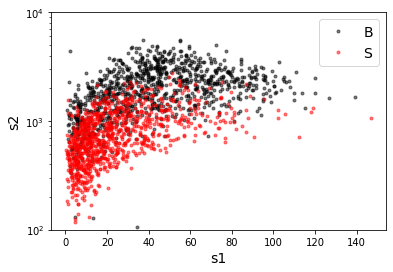

B_pdiffT.shape:  (5000,)
S_pdiffT.shape:  (5000,)


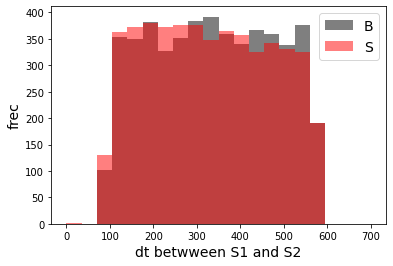

In [16]:

# CONCATENATE THE BACKGROUNDS
B_pbot = np.concatenate([B_pbot_ER[:NUM_DAT_ER], B_pbot_AC[:NUM_DAT_AC], B_pbot_CNNS[:NUM_DAT_CNNS], B_pbot_RN[:NUM_DAT_RN], B_pbot_WALL[:NUM_DAT_WALL]])
B_ptop = np.concatenate([B_ptop_ER[:NUM_DAT_ER], B_ptop_AC[:NUM_DAT_AC], B_ptop_CNNS[:NUM_DAT_CNNS], B_ptop_RN[:NUM_DAT_RN], B_ptop_WALL[:NUM_DAT_WALL]])
B_ppeakS1 = np.concatenate([B_ppeakS1_ER[:NUM_DAT_ER], B_ppeakS1_AC[:NUM_DAT_AC], B_ppeakS1_CNNS[:NUM_DAT_CNNS], B_ppeakS1_RN[:NUM_DAT_RN], B_ppeakS1_WALL[:NUM_DAT_WALL]])
B_ppeakS2 = np.concatenate([B_ppeakS2_ER[:NUM_DAT_ER], B_ppeakS2_AC[:NUM_DAT_AC], B_ppeakS2_CNNS[:NUM_DAT_CNNS], B_ppeakS2_RN[:NUM_DAT_RN], B_ppeakS2_WALL[:NUM_DAT_WALL]])

print('\nB_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


rnd = 100

B_pbot_plot, B_ptop_plot = shuffle(B_pbot, B_ptop, random_state=rnd)
S_pbot_plot, S_ptop_plot = shuffle(S_pbot, S_ptop, random_state=rnd)

plt.plot(B_pbot_plot[:1000], B_ptop_plot[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot_plot[:1000], S_ptop_plot[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()



# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [17]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 7)
B_ppeakS2.shape:  (5000, 7)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 7)
S_ppeakS2.shape:  (5000, 7)


## 1. No compressed features

In [18]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 35244)
y_mon_train :  (4999,)
X_mon_val :  (1667, 35244)
y_mon_val :  (1667,)
X_mon_test :  (3334, 35244)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68736	validation_1-logloss:0.68817
[1]	validation_0-logloss:0.68171	validation_1-logloss:0.68337
[2]	validation_0-logloss:0.67617	validation_1-logloss:0.67861
[3]	validation_0-logloss:0.67073	validation_1-logloss:0.67393
[4]	validation_0-logloss:0.66538	validation_1-logloss:0.66954
[5]	validation_0-logloss:0.66019	validation_1-logloss:0.66503
[6]	validation_0-logloss:0.65504	validation_1-logloss:0.66078
[7]	validation_0-logloss:0.64991	validation_1-logloss:0.65639
[8]	validation_0-logloss:0.64491	validation_1-logloss:0.65207
[9]	validation_0-logloss:0.63998	validation_1-logloss:0.64794
[10]	validation_0-logloss:0.63509	validation_1-logloss:0.64378
[11]	validation_0-logloss:0.63041	validation_1-logloss:0.63995
[12]	validation_0-logloss:0.62575	validation_1-logloss:0.63597
[13]	validation_0-logloss:0.62122	validation_1-logloss:0.63226
[14]	validation_0-logloss:0.61665	validation_1-logloss:0.62834
[15]	validation_0-logloss:0.61225	validation_1-logloss:0.62472
[1

[130]	validation_0-logloss:0.33444	validation_1-logloss:0.41172
[131]	validation_0-logloss:0.33304	validation_1-logloss:0.41080
[132]	validation_0-logloss:0.33169	validation_1-logloss:0.40990
[133]	validation_0-logloss:0.33041	validation_1-logloss:0.40915
[134]	validation_0-logloss:0.32905	validation_1-logloss:0.40831
[135]	validation_0-logloss:0.32760	validation_1-logloss:0.40740
[136]	validation_0-logloss:0.32638	validation_1-logloss:0.40671
[137]	validation_0-logloss:0.32502	validation_1-logloss:0.40577
[138]	validation_0-logloss:0.32371	validation_1-logloss:0.40484
[139]	validation_0-logloss:0.32254	validation_1-logloss:0.40415
[140]	validation_0-logloss:0.32120	validation_1-logloss:0.40324
[141]	validation_0-logloss:0.31994	validation_1-logloss:0.40251
[142]	validation_0-logloss:0.31862	validation_1-logloss:0.40166
[143]	validation_0-logloss:0.31751	validation_1-logloss:0.40102
[144]	validation_0-logloss:0.31626	validation_1-logloss:0.40013
[145]	validation_0-logloss:0.31505	valid

[259]	validation_0-logloss:0.21396	validation_1-logloss:0.34091
[260]	validation_0-logloss:0.21338	validation_1-logloss:0.34058
[261]	validation_0-logloss:0.21268	validation_1-logloss:0.34022
[262]	validation_0-logloss:0.21205	validation_1-logloss:0.34000
[263]	validation_0-logloss:0.21143	validation_1-logloss:0.33968
[264]	validation_0-logloss:0.21080	validation_1-logloss:0.33938
[265]	validation_0-logloss:0.21022	validation_1-logloss:0.33911
[266]	validation_0-logloss:0.20965	validation_1-logloss:0.33879
[267]	validation_0-logloss:0.20897	validation_1-logloss:0.33848
[268]	validation_0-logloss:0.20830	validation_1-logloss:0.33820
[269]	validation_0-logloss:0.20775	validation_1-logloss:0.33783
[270]	validation_0-logloss:0.20716	validation_1-logloss:0.33753
[271]	validation_0-logloss:0.20656	validation_1-logloss:0.33726
[272]	validation_0-logloss:0.20609	validation_1-logloss:0.33708
[273]	validation_0-logloss:0.20559	validation_1-logloss:0.33679
[274]	validation_0-logloss:0.20495	valid

[388]	validation_0-logloss:0.15388	validation_1-logloss:0.31378
[389]	validation_0-logloss:0.15355	validation_1-logloss:0.31364
[390]	validation_0-logloss:0.15319	validation_1-logloss:0.31347
[391]	validation_0-logloss:0.15293	validation_1-logloss:0.31341
[392]	validation_0-logloss:0.15255	validation_1-logloss:0.31326
[393]	validation_0-logloss:0.15210	validation_1-logloss:0.31308
[394]	validation_0-logloss:0.15185	validation_1-logloss:0.31299
[395]	validation_0-logloss:0.15145	validation_1-logloss:0.31277
[396]	validation_0-logloss:0.15105	validation_1-logloss:0.31255
[397]	validation_0-logloss:0.15076	validation_1-logloss:0.31234
[398]	validation_0-logloss:0.15042	validation_1-logloss:0.31222
[399]	validation_0-logloss:0.14999	validation_1-logloss:0.31208
[400]	validation_0-logloss:0.14974	validation_1-logloss:0.31196
[401]	validation_0-logloss:0.14946	validation_1-logloss:0.31182
[402]	validation_0-logloss:0.14914	validation_1-logloss:0.31163
[403]	validation_0-logloss:0.14889	valid

[517]	validation_0-logloss:0.11802	validation_1-logloss:0.30033
[518]	validation_0-logloss:0.11786	validation_1-logloss:0.30029
[519]	validation_0-logloss:0.11759	validation_1-logloss:0.30029
[520]	validation_0-logloss:0.11748	validation_1-logloss:0.30022
[521]	validation_0-logloss:0.11720	validation_1-logloss:0.30012
[522]	validation_0-logloss:0.11700	validation_1-logloss:0.30014
[523]	validation_0-logloss:0.11677	validation_1-logloss:0.30004
[524]	validation_0-logloss:0.11657	validation_1-logloss:0.29994
[525]	validation_0-logloss:0.11638	validation_1-logloss:0.29995
[526]	validation_0-logloss:0.11620	validation_1-logloss:0.29987
[527]	validation_0-logloss:0.11594	validation_1-logloss:0.29978
[528]	validation_0-logloss:0.11575	validation_1-logloss:0.29970
[529]	validation_0-logloss:0.11552	validation_1-logloss:0.29960
[530]	validation_0-logloss:0.11541	validation_1-logloss:0.29957
[531]	validation_0-logloss:0.11520	validation_1-logloss:0.29948
[532]	validation_0-logloss:0.11501	valid

[646]	validation_0-logloss:0.09641	validation_1-logloss:0.29342
[647]	validation_0-logloss:0.09624	validation_1-logloss:0.29342
[648]	validation_0-logloss:0.09613	validation_1-logloss:0.29342
[649]	validation_0-logloss:0.09596	validation_1-logloss:0.29339
[650]	validation_0-logloss:0.09581	validation_1-logloss:0.29331
[651]	validation_0-logloss:0.09570	validation_1-logloss:0.29326
[652]	validation_0-logloss:0.09559	validation_1-logloss:0.29325
[653]	validation_0-logloss:0.09545	validation_1-logloss:0.29320
[654]	validation_0-logloss:0.09536	validation_1-logloss:0.29318
[655]	validation_0-logloss:0.09524	validation_1-logloss:0.29317
[656]	validation_0-logloss:0.09515	validation_1-logloss:0.29310
[657]	validation_0-logloss:0.09500	validation_1-logloss:0.29305
[658]	validation_0-logloss:0.09487	validation_1-logloss:0.29305
[659]	validation_0-logloss:0.09471	validation_1-logloss:0.29302
[660]	validation_0-logloss:0.09458	validation_1-logloss:0.29304
[661]	validation_0-logloss:0.09448	valid

[775]	validation_0-logloss:0.08179	validation_1-logloss:0.29038
[776]	validation_0-logloss:0.08165	validation_1-logloss:0.29032
[777]	validation_0-logloss:0.08158	validation_1-logloss:0.29030
[778]	validation_0-logloss:0.08149	validation_1-logloss:0.29031
[779]	validation_0-logloss:0.08138	validation_1-logloss:0.29025
[780]	validation_0-logloss:0.08132	validation_1-logloss:0.29024
[781]	validation_0-logloss:0.08119	validation_1-logloss:0.29018
[782]	validation_0-logloss:0.08108	validation_1-logloss:0.29018
[783]	validation_0-logloss:0.08096	validation_1-logloss:0.29017
[784]	validation_0-logloss:0.08086	validation_1-logloss:0.29015
[785]	validation_0-logloss:0.08078	validation_1-logloss:0.29017
[786]	validation_0-logloss:0.08064	validation_1-logloss:0.29019
[787]	validation_0-logloss:0.08053	validation_1-logloss:0.29015
[788]	validation_0-logloss:0.08044	validation_1-logloss:0.29018
[789]	validation_0-logloss:0.08031	validation_1-logloss:0.29016
[790]	validation_0-logloss:0.08024	valid

[904]	validation_0-logloss:0.07026	validation_1-logloss:0.28923
[905]	validation_0-logloss:0.07019	validation_1-logloss:0.28922
[906]	validation_0-logloss:0.07011	validation_1-logloss:0.28917
[907]	validation_0-logloss:0.07000	validation_1-logloss:0.28917
[908]	validation_0-logloss:0.06995	validation_1-logloss:0.28917
[909]	validation_0-logloss:0.06990	validation_1-logloss:0.28913
[910]	validation_0-logloss:0.06981	validation_1-logloss:0.28918
[911]	validation_0-logloss:0.06970	validation_1-logloss:0.28913
[912]	validation_0-logloss:0.06959	validation_1-logloss:0.28905
[913]	validation_0-logloss:0.06950	validation_1-logloss:0.28901
[914]	validation_0-logloss:0.06945	validation_1-logloss:0.28902
[915]	validation_0-logloss:0.06939	validation_1-logloss:0.28896
[916]	validation_0-logloss:0.06930	validation_1-logloss:0.28890
[917]	validation_0-logloss:0.06922	validation_1-logloss:0.28891
[918]	validation_0-logloss:0.06918	validation_1-logloss:0.28895
[919]	validation_0-logloss:0.06910	valid

[1032]	validation_0-logloss:0.06139	validation_1-logloss:0.28870
[1033]	validation_0-logloss:0.06133	validation_1-logloss:0.28876
[1034]	validation_0-logloss:0.06125	validation_1-logloss:0.28872
[1035]	validation_0-logloss:0.06118	validation_1-logloss:0.28870
[1036]	validation_0-logloss:0.06110	validation_1-logloss:0.28874
[1037]	validation_0-logloss:0.06103	validation_1-logloss:0.28877
[1038]	validation_0-logloss:0.06098	validation_1-logloss:0.28874
[1039]	validation_0-logloss:0.06092	validation_1-logloss:0.28877
[1040]	validation_0-logloss:0.06085	validation_1-logloss:0.28872
[1041]	validation_0-logloss:0.06083	validation_1-logloss:0.28871
[1042]	validation_0-logloss:0.06076	validation_1-logloss:0.28874
[1043]	validation_0-logloss:0.06069	validation_1-logloss:0.28881
[1044]	validation_0-logloss:0.06061	validation_1-logloss:0.28881
[1045]	validation_0-logloss:0.06056	validation_1-logloss:0.28884
[1046]	validation_0-logloss:0.06051	validation_1-logloss:0.28879
[1047]	validation_0-loglo

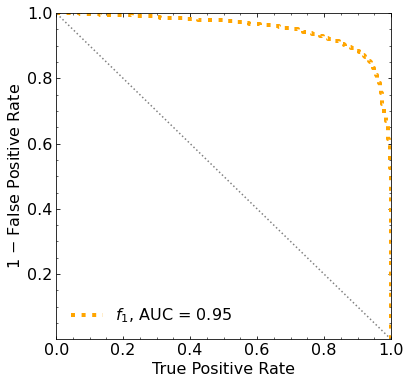

Classification score:


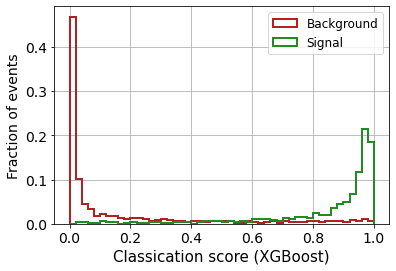


 ROC-AUC =  0.952054232427156


In [19]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [20]:
np.savetxt('rocs/roc_arrays.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.952054232427156


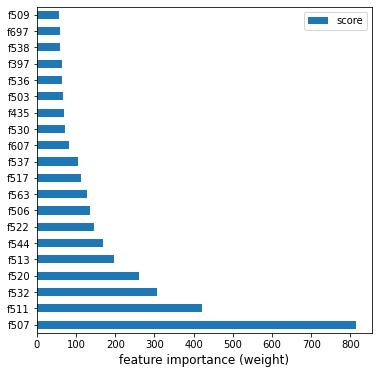

In [21]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN
lots of tests, the best is:

Dense layers: 1-4-8-16-32-64-128-256, 

Activation: LeakyReLu

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 281960    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8)                 0         
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4151 - accuracy: 0.8170 - val_loss: 0.4005 - val_accuracy: 0.8122
Epoch 51/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4153 - accuracy: 0.8210 - val_loss: 0.4035 - val_accuracy: 0.8110
Epoch 52/500
40/40 [==============================] - 0s 7ms/step - loss: 0.4125 - accuracy: 0.8183 - val_loss: 0.4002 - val_accuracy: 0.8230
Epoch 53/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4177 - accuracy: 0.8164 - val_loss: 0.3854 - val_accuracy: 0.8236
Epoch 54/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3993 - accuracy: 0.8230 - val_loss: 0.3952 - val_accuracy: 0.8278
Epoch 55/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4106 - accuracy: 0.8196 - val_loss: 0.3873 - val_accuracy: 0.8254
Epoch 56/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3885 - accuracy: 0.8298 - val_loss: 0.3997 - val_accuracy: 0.8260
Epoch 

40/40 [==============================] - 0s 6ms/step - loss: 0.3671 - accuracy: 0.8402 - val_loss: 0.3920 - val_accuracy: 0.8296
Epoch 165/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3573 - accuracy: 0.8545 - val_loss: 0.4234 - val_accuracy: 0.8440
Epoch 166/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3344 - accuracy: 0.8612 - val_loss: 0.3733 - val_accuracy: 0.8362
Epoch 167/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3262 - accuracy: 0.8656 - val_loss: 0.3658 - val_accuracy: 0.8386
Epoch 168/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3542 - accuracy: 0.8520 - val_loss: 0.3683 - val_accuracy: 0.8434
Epoch 169/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3281 - accuracy: 0.8646 - val_loss: 0.3683 - val_accuracy: 0.8470
Epoch 170/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3519 - accuracy: 0.8558 - val_loss: 0.3960 - val_accuracy: 0.8110
Epoch 171/500

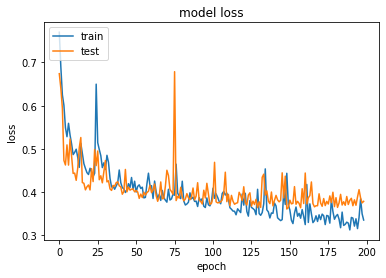

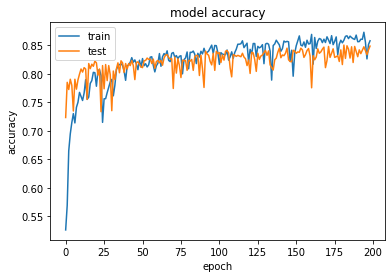

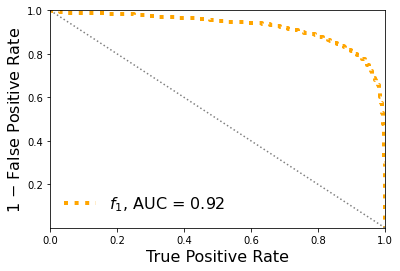

Classification score:


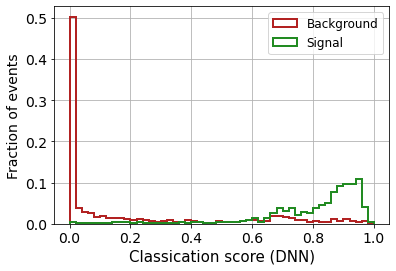


 ROC-AUC =  0.9240158602638194


In [23]:

# define the keras model
model = Sequential()
model.add(Dense(8, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [24]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9240158602638194


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                563920    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4374 - accuracy: 0.8069 - val_loss: 0.4218 - val_accuracy: 0.7900
Epoch 51/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4368 - accuracy: 0.7974 - val_loss: 0.3850 - val_accuracy: 0.8272
Epoch 52/500
40/40 [==============================] - 0s 7ms/step - loss: 0.4138 - accuracy: 0.8189 - val_loss: 0.3928 - val_accuracy: 0.8296
Epoch 53/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3982 - accuracy: 0.8228 - val_loss: 0.3871 - val_accuracy: 0.8260
Epoch 54/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3825 - accuracy: 0.8393 - val_loss: 0.3862 - val_accuracy: 0.8266
Epoch 55/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4203 - accuracy: 0.8142 - val_loss: 0.4143 - val_accuracy: 0.8326
Epoch 56/500
40/40 [==============================] - 0s 6ms/step - loss: 0.4010 - accuracy: 0.8233 - val_loss: 0.4100 - val_accuracy: 0.8092
Epoch 

40/40 [==============================] - 0s 6ms/step - loss: 0.3458 - accuracy: 0.8465 - val_loss: 0.4045 - val_accuracy: 0.8320
Epoch 165/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3363 - accuracy: 0.8607 - val_loss: 0.3771 - val_accuracy: 0.8368
Epoch 166/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3464 - accuracy: 0.8470 - val_loss: 0.3799 - val_accuracy: 0.8332
Epoch 167/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3290 - accuracy: 0.8560 - val_loss: 0.3733 - val_accuracy: 0.8362
Epoch 168/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3279 - accuracy: 0.8591 - val_loss: 0.3945 - val_accuracy: 0.8422
Epoch 169/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3373 - accuracy: 0.8608 - val_loss: 0.3817 - val_accuracy: 0.8404
Epoch 170/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3214 - accuracy: 0.8668 - val_loss: 0.4115 - val_accuracy: 0.8314
Epoch 171/500

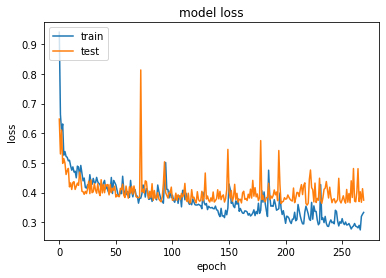

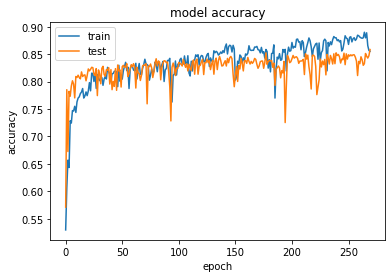

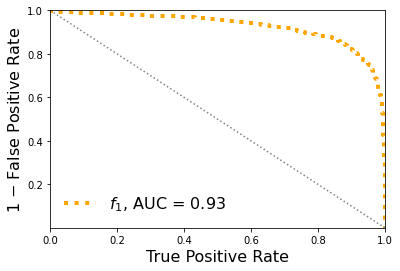

Classification score:


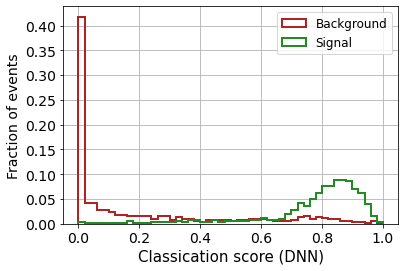


 ROC-AUC =  0.9256877676131571


In [25]:

# define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [26]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9256877676131571


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1127840   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

Epoch 102/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3885 - accuracy: 0.8321 - val_loss: 0.3982 - val_accuracy: 0.8266
Epoch 103/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3960 - accuracy: 0.8278 - val_loss: 0.3925 - val_accuracy: 0.8104
Epoch 104/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3774 - accuracy: 0.8427 - val_loss: 0.3718 - val_accuracy: 0.8356
Epoch 105/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3691 - accuracy: 0.8397 - val_loss: 0.4037 - val_accuracy: 0.8266
Epoch 106/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3803 - accuracy: 0.8349 - val_loss: 0.3831 - val_accuracy: 0.8374
Epoch 107/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3619 - accuracy: 0.8496 - val_loss: 0.4396 - val_accuracy: 0.8188
Epoch 108/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3970 - accuracy: 0.8289 - val_loss: 0.3899 - val_accuracy: 0.8410

40/40 [==============================] - 0s 7ms/step - loss: 0.3639 - accuracy: 0.8415 - val_loss: 0.3725 - val_accuracy: 0.8446
Epoch 217/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3607 - accuracy: 0.8553 - val_loss: 0.3686 - val_accuracy: 0.8440
Epoch 218/500
40/40 [==============================] - 0s 7ms/step - loss: 0.4232 - accuracy: 0.8197 - val_loss: 0.3733 - val_accuracy: 0.8416
Epoch 219/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3513 - accuracy: 0.8557 - val_loss: 0.3670 - val_accuracy: 0.8470
Epoch 220/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3384 - accuracy: 0.8601 - val_loss: 0.3607 - val_accuracy: 0.8488
Epoch 221/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3346 - accuracy: 0.8591 - val_loss: 0.4249 - val_accuracy: 0.8092
Epoch 222/500
40/40 [==============================] - 0s 7ms/step - loss: 0.3293 - accuracy: 0.8535 - val_loss: 0.3932 - val_accuracy: 0.8326
Restoring mod

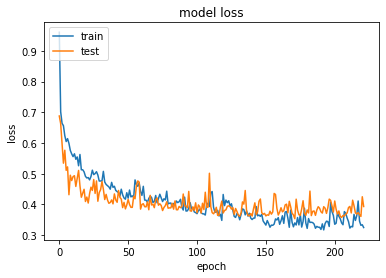

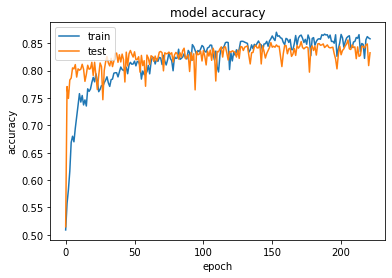

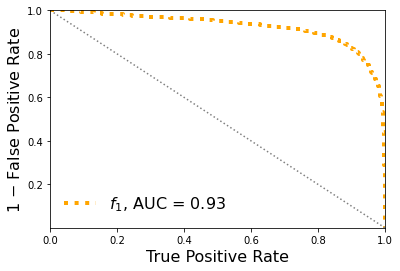

Classification score:


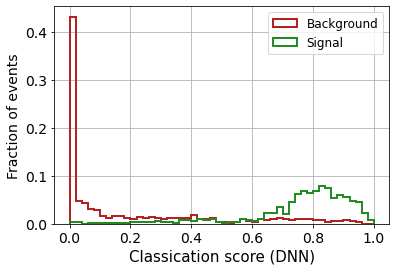


 ROC-AUC =  0.9253573454502524


In [27]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [28]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9253573454502524


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                2255680   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)               

40/40 [==============================] - 0s 11ms/step - loss: 0.4552 - accuracy: 0.8058 - val_loss: 0.4420 - val_accuracy: 0.8230
Epoch 42/500
40/40 [==============================] - 0s 11ms/step - loss: 0.4569 - accuracy: 0.8092 - val_loss: 0.4563 - val_accuracy: 0.8152
Epoch 43/500
40/40 [==============================] - 0s 11ms/step - loss: 0.4560 - accuracy: 0.8061 - val_loss: 0.4142 - val_accuracy: 0.8044
Epoch 44/500
40/40 [==============================] - 0s 11ms/step - loss: 0.4946 - accuracy: 0.7815 - val_loss: 0.4406 - val_accuracy: 0.7660
Epoch 45/500
40/40 [==============================] - 0s 11ms/step - loss: 0.4412 - accuracy: 0.7980 - val_loss: 0.4137 - val_accuracy: 0.8110
Epoch 46/500
40/40 [==============================] - 0s 11ms/step - loss: 0.4476 - accuracy: 0.8105 - val_loss: 0.4075 - val_accuracy: 0.8164
Epoch 47/500
40/40 [==============================] - 0s 11ms/step - loss: 0.4413 - accuracy: 0.8091 - val_loss: 0.4190 - val_accuracy: 0.8182
Epoch 48/500

Epoch 155/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3583 - accuracy: 0.8505 - val_loss: 0.3743 - val_accuracy: 0.8374
Epoch 156/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3511 - accuracy: 0.8532 - val_loss: 0.3636 - val_accuracy: 0.8434
Epoch 157/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3340 - accuracy: 0.8577 - val_loss: 0.3736 - val_accuracy: 0.8296
Epoch 158/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3727 - accuracy: 0.8392 - val_loss: 0.3617 - val_accuracy: 0.8404
Epoch 159/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3088 - accuracy: 0.8656 - val_loss: 0.3675 - val_accuracy: 0.8404
Epoch 160/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3341 - accuracy: 0.8596 - val_loss: 0.3911 - val_accuracy: 0.8284
Epoch 161/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3357 - accuracy: 0.8569 - val_loss: 0.3721 - val_accuracy:

Epoch 212/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3089 - accuracy: 0.8659 - val_loss: 0.4191 - val_accuracy: 0.8158
Epoch 213/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3380 - accuracy: 0.8498 - val_loss: 0.3946 - val_accuracy: 0.8338
Epoch 214/500
40/40 [==============================] - 0s 12ms/step - loss: 0.3310 - accuracy: 0.8530 - val_loss: 0.3778 - val_accuracy: 0.8428
Epoch 215/500
40/40 [==============================] - 0s 12ms/step - loss: 0.3256 - accuracy: 0.8580 - val_loss: 0.4181 - val_accuracy: 0.8296
Epoch 216/500
40/40 [==============================] - 0s 12ms/step - loss: 0.2990 - accuracy: 0.8690 - val_loss: 0.3855 - val_accuracy: 0.8332
Epoch 217/500
40/40 [==============================] - 0s 12ms/step - loss: 0.3318 - accuracy: 0.8657 - val_loss: 0.3578 - val_accuracy: 0.8464
Epoch 218/500
40/40 [==============================] - 0s 11ms/step - loss: 0.3223 - accuracy: 0.8705 - val_loss: 0.3749 - val_accuracy:

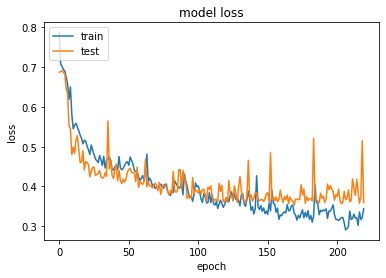

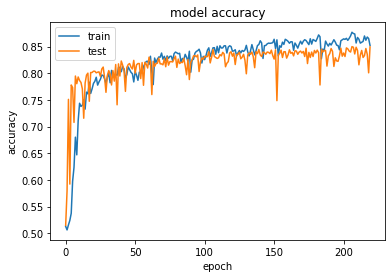

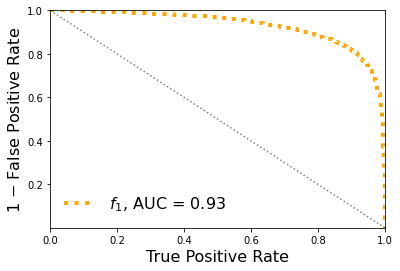

Classification score:


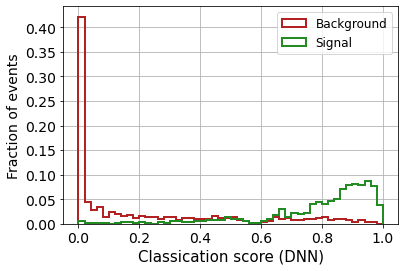


 ROC-AUC =  0.9297795313908255


In [29]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [30]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9297795313908255


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               4511360   
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

40/40 [==============================] - 1s 18ms/step - loss: 0.4767 - accuracy: 0.8026 - val_loss: 0.3828 - val_accuracy: 0.8386
Epoch 96/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3937 - accuracy: 0.8300 - val_loss: 0.4018 - val_accuracy: 0.8194
Epoch 97/500
40/40 [==============================] - 1s 18ms/step - loss: 0.4656 - accuracy: 0.8105 - val_loss: 0.4004 - val_accuracy: 0.8386
Epoch 98/500
40/40 [==============================] - 1s 18ms/step - loss: 0.4006 - accuracy: 0.8358 - val_loss: 0.4020 - val_accuracy: 0.8302
Epoch 99/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3845 - accuracy: 0.8365 - val_loss: 0.3836 - val_accuracy: 0.8362
Epoch 100/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3731 - accuracy: 0.8414 - val_loss: 0.3606 - val_accuracy: 0.8416
Epoch 101/500
40/40 [==============================] - 1s 18ms/step - loss: 0.4156 - accuracy: 0.8224 - val_loss: 0.3699 - val_accuracy: 0.8434
Epoch 102/

40/40 [==============================] - 1s 18ms/step - loss: 0.3537 - accuracy: 0.8552 - val_loss: 0.3544 - val_accuracy: 0.8494
Epoch 153/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3283 - accuracy: 0.8601 - val_loss: 0.3738 - val_accuracy: 0.8344
Epoch 154/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3760 - accuracy: 0.8423 - val_loss: 0.4450 - val_accuracy: 0.8050
Epoch 155/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3706 - accuracy: 0.8491 - val_loss: 0.3506 - val_accuracy: 0.8398
Epoch 156/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3531 - accuracy: 0.8566 - val_loss: 0.3581 - val_accuracy: 0.8362
Epoch 157/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3582 - accuracy: 0.8486 - val_loss: 0.3723 - val_accuracy: 0.8320
Epoch 158/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3376 - accuracy: 0.8656 - val_loss: 0.3607 - val_accuracy: 0.8398
Epoch 

Epoch 209/500
40/40 [==============================] - 1s 18ms/step - loss: 0.2936 - accuracy: 0.8701 - val_loss: 0.3909 - val_accuracy: 0.8440
Epoch 210/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3075 - accuracy: 0.8678 - val_loss: 0.3937 - val_accuracy: 0.8398
Epoch 211/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3139 - accuracy: 0.8739 - val_loss: 0.3880 - val_accuracy: 0.8446
Epoch 212/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3268 - accuracy: 0.8725 - val_loss: 0.3882 - val_accuracy: 0.8410
Epoch 213/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3205 - accuracy: 0.8679 - val_loss: 0.3909 - val_accuracy: 0.8380
Epoch 214/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3186 - accuracy: 0.8675 - val_loss: 0.3762 - val_accuracy: 0.8416
Epoch 215/500
40/40 [==============================] - 1s 18ms/step - loss: 0.3165 - accuracy: 0.8651 - val_loss: 0.3757 - val_accuracy:

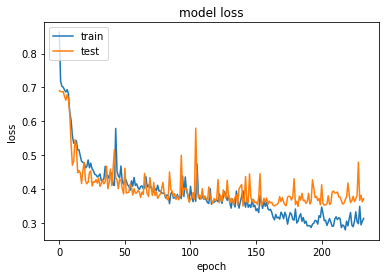

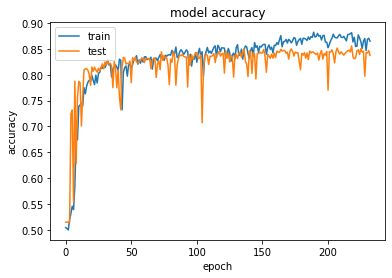

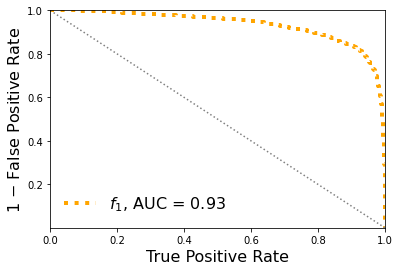

Classification score:


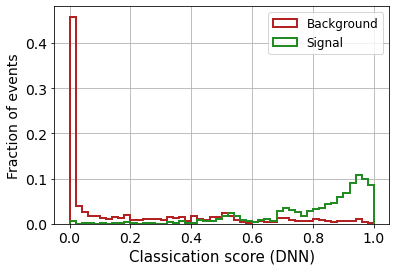


 ROC-AUC =  0.9337510762116199


In [31]:

# define the keras model
model = Sequential()
model.add(Dense(128, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [32]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9337510762116199


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               9022720   
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)               

40/40 [==============================] - 1s 34ms/step - loss: 0.3715 - accuracy: 0.8546 - val_loss: 0.3687 - val_accuracy: 0.8338
Epoch 93/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3678 - accuracy: 0.8483 - val_loss: 0.3799 - val_accuracy: 0.8410
Epoch 94/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3661 - accuracy: 0.8432 - val_loss: 0.3769 - val_accuracy: 0.8380
Epoch 95/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3459 - accuracy: 0.8478 - val_loss: 0.3706 - val_accuracy: 0.8368
Epoch 96/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3510 - accuracy: 0.8488 - val_loss: 0.3673 - val_accuracy: 0.8392
Epoch 97/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3488 - accuracy: 0.8560 - val_loss: 0.3833 - val_accuracy: 0.8278
Epoch 98/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3740 - accuracy: 0.8388 - val_loss: 0.3832 - val_accuracy: 0.8290
Epoch 99/500

40/40 [==============================] - 1s 31ms/step - loss: 0.3215 - accuracy: 0.8638 - val_loss: 0.3806 - val_accuracy: 0.8410
Epoch 150/500
40/40 [==============================] - 1s 32ms/step - loss: 0.3272 - accuracy: 0.8657 - val_loss: 0.4238 - val_accuracy: 0.7864
Epoch 151/500
40/40 [==============================] - 1s 32ms/step - loss: 0.3464 - accuracy: 0.8412 - val_loss: 0.4443 - val_accuracy: 0.7774
Epoch 152/500
40/40 [==============================] - 1s 31ms/step - loss: 0.3298 - accuracy: 0.8532 - val_loss: 0.3645 - val_accuracy: 0.8482
Epoch 153/500
40/40 [==============================] - 1s 31ms/step - loss: 0.2997 - accuracy: 0.8746 - val_loss: 0.3590 - val_accuracy: 0.8428
Epoch 154/500
40/40 [==============================] - 1s 31ms/step - loss: 0.3115 - accuracy: 0.8752 - val_loss: 0.4219 - val_accuracy: 0.8110
Epoch 155/500
40/40 [==============================] - 1s 32ms/step - loss: 0.3248 - accuracy: 0.8631 - val_loss: 0.4206 - val_accuracy: 0.7804
Epoch 

Epoch 206/500
40/40 [==============================] - 1s 31ms/step - loss: 0.3234 - accuracy: 0.8642 - val_loss: 0.4980 - val_accuracy: 0.8290
Epoch 207/500
40/40 [==============================] - 1s 32ms/step - loss: 0.3466 - accuracy: 0.8517 - val_loss: 0.3742 - val_accuracy: 0.8530
Epoch 208/500
40/40 [==============================] - 1s 32ms/step - loss: 0.2958 - accuracy: 0.8738 - val_loss: 0.3859 - val_accuracy: 0.8452
Epoch 209/500
40/40 [==============================] - 1s 32ms/step - loss: 0.2962 - accuracy: 0.8681 - val_loss: 0.3663 - val_accuracy: 0.8392
Restoring model weights from the end of the best epoch.
Epoch 00209: early stopping


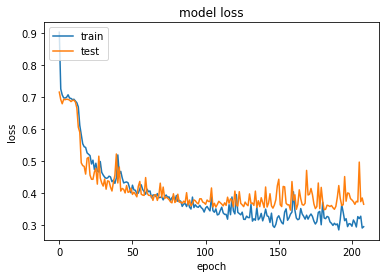

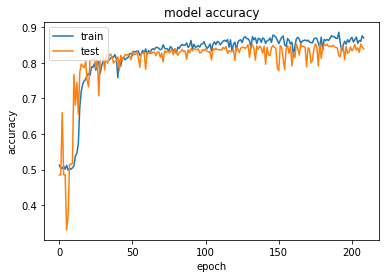

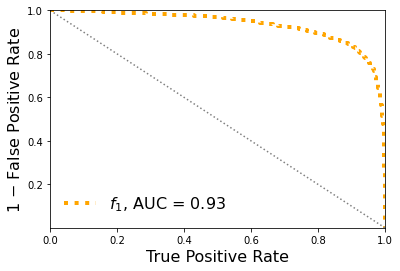

Classification score:


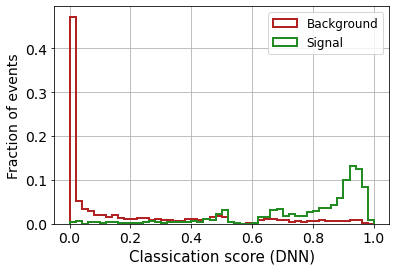


 ROC-AUC =  0.9344673508349098


In [33]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [34]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9344673508349098


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               9022720   
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)               

40/40 [==============================] - 1s 33ms/step - loss: 0.4439 - accuracy: 0.8122 - val_loss: 0.4043 - val_accuracy: 0.8272
Epoch 93/500
40/40 [==============================] - 1s 33ms/step - loss: 0.4123 - accuracy: 0.8277 - val_loss: 0.4047 - val_accuracy: 0.8242
Epoch 94/500
40/40 [==============================] - 1s 33ms/step - loss: 0.4087 - accuracy: 0.8299 - val_loss: 0.3871 - val_accuracy: 0.8320
Epoch 95/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3968 - accuracy: 0.8327 - val_loss: 0.4009 - val_accuracy: 0.8212
Epoch 96/500
40/40 [==============================] - 1s 33ms/step - loss: 0.4104 - accuracy: 0.8229 - val_loss: 0.3934 - val_accuracy: 0.8314
Epoch 97/500
40/40 [==============================] - 1s 33ms/step - loss: 0.4013 - accuracy: 0.8349 - val_loss: 0.3900 - val_accuracy: 0.8290
Epoch 98/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3733 - accuracy: 0.8459 - val_loss: 0.3939 - val_accuracy: 0.8284
Epoch 99/500

40/40 [==============================] - 1s 34ms/step - loss: 0.3171 - accuracy: 0.8610 - val_loss: 0.3792 - val_accuracy: 0.8248
Epoch 150/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3348 - accuracy: 0.8678 - val_loss: 0.3853 - val_accuracy: 0.8332
Epoch 151/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3516 - accuracy: 0.8618 - val_loss: 0.3665 - val_accuracy: 0.8320
Epoch 152/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3692 - accuracy: 0.8410 - val_loss: 0.3768 - val_accuracy: 0.8296
Epoch 153/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3582 - accuracy: 0.8500 - val_loss: 0.3875 - val_accuracy: 0.8332
Epoch 154/500
40/40 [==============================] - 1s 32ms/step - loss: 0.4029 - accuracy: 0.8308 - val_loss: 0.3685 - val_accuracy: 0.8398
Epoch 155/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3699 - accuracy: 0.8423 - val_loss: 0.3868 - val_accuracy: 0.8152
Epoch 

Epoch 206/500
40/40 [==============================] - 1s 33ms/step - loss: 0.2819 - accuracy: 0.8858 - val_loss: 0.3662 - val_accuracy: 0.8464
Epoch 207/500
40/40 [==============================] - 1s 32ms/step - loss: 0.2974 - accuracy: 0.8718 - val_loss: 0.4656 - val_accuracy: 0.8110
Epoch 208/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3229 - accuracy: 0.8696 - val_loss: 0.3696 - val_accuracy: 0.8296
Epoch 209/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3176 - accuracy: 0.8697 - val_loss: 0.3721 - val_accuracy: 0.8344
Epoch 210/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3078 - accuracy: 0.8701 - val_loss: 0.4490 - val_accuracy: 0.8044
Epoch 211/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3964 - accuracy: 0.8352 - val_loss: 0.3650 - val_accuracy: 0.8434
Epoch 212/500
40/40 [==============================] - 1s 34ms/step - loss: 0.3318 - accuracy: 0.8555 - val_loss: 0.3708 - val_accuracy:

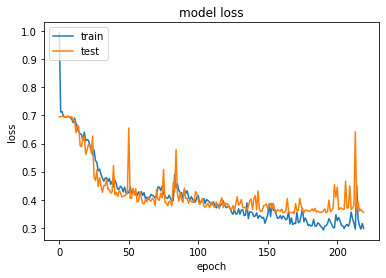

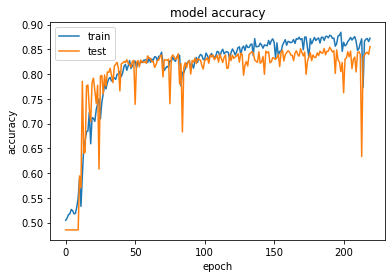

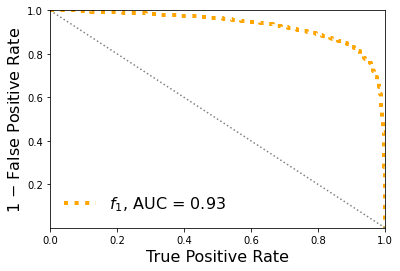

Classification score:


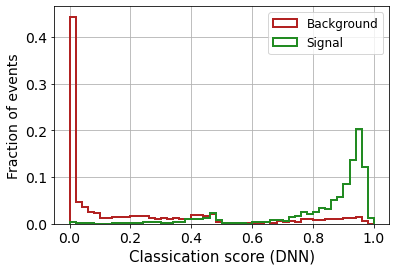


 ROC-AUC =  0.9327310147631758


In [35]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [36]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9327310147631758


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                1127840   
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_27 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5935 - accuracy: 0.7027 - val_loss: 0.4991 - val_accuracy: 0.8074
Epoch 51/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5459 - accuracy: 0.7513 - val_loss: 0.4669 - val_accuracy: 0.8284
Epoch 52/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5410 - accuracy: 0.7612 - val_loss: 0.4801 - val_accuracy: 0.8218
Epoch 53/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5274 - accuracy: 0.7658 - val_loss: 0.4639 - val_accuracy: 0.8278
Epoch 54/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5431 - accuracy: 0.7601 - val_loss: 0.4650 - val_accuracy: 0.8272
Epoch 55/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5411 - accuracy: 0.7629 - val_loss: 0.4629 - val_accuracy: 0.8272
Epoch 56/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5411 - accuracy: 0.7715 - val_loss: 0.4694 - val_accuracy: 0.8170
Epoch 

40/40 [==============================] - 0s 8ms/step - loss: 0.4762 - accuracy: 0.8008 - val_loss: 0.4673 - val_accuracy: 0.8236
Epoch 165/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4766 - accuracy: 0.7961 - val_loss: 0.4437 - val_accuracy: 0.8458
Epoch 166/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4903 - accuracy: 0.7913 - val_loss: 0.6068 - val_accuracy: 0.6773
Epoch 167/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5166 - accuracy: 0.7697 - val_loss: 0.4323 - val_accuracy: 0.8422
Epoch 168/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4850 - accuracy: 0.7907 - val_loss: 0.4273 - val_accuracy: 0.8410
Epoch 169/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4737 - accuracy: 0.8023 - val_loss: 0.4319 - val_accuracy: 0.8464
Epoch 170/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4715 - accuracy: 0.7992 - val_loss: 0.4904 - val_accuracy: 0.8008
Epoch 171/500

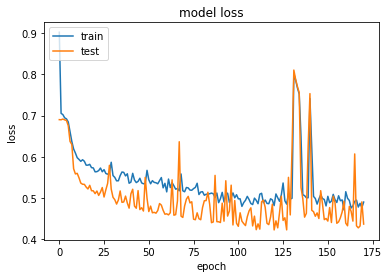

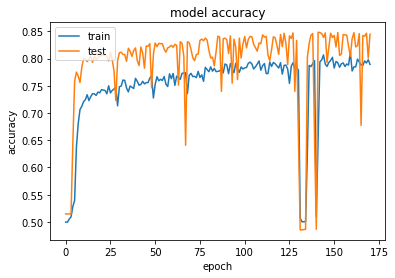

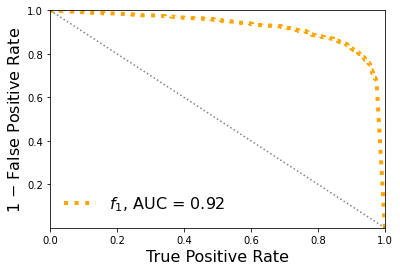

Classification score:


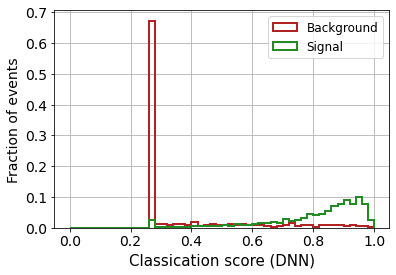


 ROC-AUC =  0.9206234540705995


In [44]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [45]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9206234540705995


### CNN

model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

In [19]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

In [20]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

Epoch 1/500
40/40 [==============================] - 130s 3s/step - loss: 8.2435 - accuracy: 0.5153 - val_loss: 1.3786 - val_accuracy: 0.7319
Epoch 2/500
40/40 [==============================] - 121s 3s/step - loss: 1.3185 - accuracy: 0.7076 - val_loss: 1.1327 - val_accuracy: 0.7636
Epoch 3/500
40/40 [==============================] - 121s 3s/step - loss: 1.1003 - accuracy: 0.7686 - val_loss: 1.0042 - val_accuracy: 0.7744
Epoch 4/500
40/40 [==============================] - 121s 3s/step - loss: 1.0155 - accuracy: 0.7538 - val_loss: 0.9557 - val_accuracy: 0.7738
Epoch 5/500
40/40 [==============================] - 121s 3s/step - loss: 0.9548 - accuracy: 0.7645 - val_loss: 0.9624 - val_accuracy: 0.7127
Epoch 6/500
40/40 [==============================] - 121s 3s/step - loss: 0.9228 - accuracy: 0.7514 - val_loss: 0.8641 - val_accuracy: 0.7846
Epoch 7/500
40/40 [==============================] - 121s 3s/step - loss: 0.8617 - accuracy: 0.7783 - val_loss: 0.8406 - val_accuracy: 0.7864
Epoch 

KeyboardInterrupt: 

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

Epoch 1/500
40/40 [==============================] - 17s 390ms/step - loss: 5.0216 - accuracy: 0.5301 - val_loss: 0.6238 - val_accuracy: 0.7696
Epoch 2/500
40/40 [==============================] - 15s 377ms/step - loss: 1.0962 - accuracy: 0.6151 - val_loss: 0.6410 - val_accuracy: 0.7253
Epoch 3/500
40/40 [==============================] - 16s 394ms/step - loss: 0.8164 - accuracy: 0.6926 - val_loss: 0.6049 - val_accuracy: 0.7810
Epoch 4/500
40/40 [==============================] - 16s 390ms/step - loss: 0.6420 - accuracy: 0.7420 - val_loss: 0.5111 - val_accuracy: 0.7882
Epoch 5/500
40/40 [==============================] - 15s 388ms/step - loss: 0.5954 - accuracy: 0.7581 - val_loss: 0.5231 - val_accuracy: 0.7894
Epoch 6/500
40/40 [==============================] - 16s 390ms/step - loss: 0.6530 - accuracy: 0.7450 - val_loss: 0.5320 - val_accuracy: 0.7906
Epoch 7/500
40/40 [==============================] - 16s 395ms/step - loss: 0.7237 - accuracy: 0.7464 - val_loss: 0.6627 - val_accuracy:

40/40 [==============================] - 15s 380ms/step - loss: 0.5069 - accuracy: 0.7893 - val_loss: 0.5390 - val_accuracy: 0.7738
Epoch 114/500
40/40 [==============================] - 15s 380ms/step - loss: 0.4814 - accuracy: 0.8047 - val_loss: 0.5177 - val_accuracy: 0.7948
Epoch 115/500
40/40 [==============================] - 15s 382ms/step - loss: 0.5317 - accuracy: 0.7756 - val_loss: 0.6289 - val_accuracy: 0.6437
Epoch 116/500
40/40 [==============================] - 15s 381ms/step - loss: 0.6498 - accuracy: 0.6810 - val_loss: 0.5335 - val_accuracy: 0.7942
Epoch 117/500
40/40 [==============================] - 15s 381ms/step - loss: 0.5528 - accuracy: 0.7816 - val_loss: 0.5400 - val_accuracy: 0.7714
Epoch 118/500
40/40 [==============================] - 15s 383ms/step - loss: 0.5379 - accuracy: 0.7862 - val_loss: 0.6959 - val_accuracy: 0.6305
Epoch 119/500
40/40 [==============================] - 15s 381ms/step - loss: 0.6975 - accuracy: 0.6599 - val_loss: 0.5764 - val_accuracy:

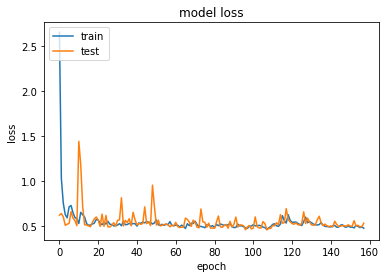

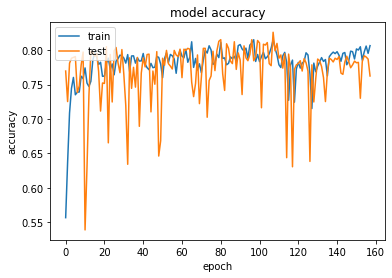

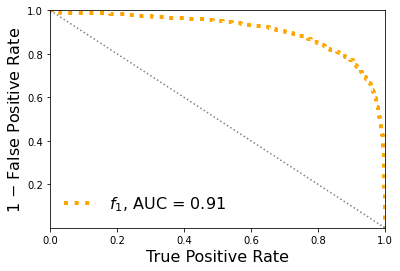

Classification score:


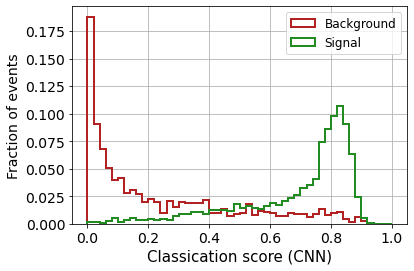


 ROC-AUC =  0.9072359574180135


In [41]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [42]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9072359574180135


In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

Epoch 1/500
40/40 [==============================] - 31s 751ms/step - loss: 6.6706 - accuracy: 0.5406 - val_loss: 1.0646 - val_accuracy: 0.6695
Epoch 2/500
40/40 [==============================] - 30s 745ms/step - loss: 1.8363 - accuracy: 0.6036 - val_loss: 0.7526 - val_accuracy: 0.7792
Epoch 3/500
40/40 [==============================] - 30s 743ms/step - loss: 1.2182 - accuracy: 0.6757 - val_loss: 0.6219 - val_accuracy: 0.7876
Epoch 4/500
11/40 [=======>......................] - ETA: 20s - loss: 0.8365 - accuracy: 0.7110

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

##### 2 conv layers

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

##### 3 conv layers

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

Epoch 1/500
40/40 [==============================] - 23s 549ms/step - loss: 1.9601 - accuracy: 0.6111 - val_loss: 0.5708 - val_accuracy: 0.7433
Epoch 2/500
40/40 [==============================] - 22s 555ms/step - loss: 0.5926 - accuracy: 0.7239 - val_loss: 0.5482 - val_accuracy: 0.7546
Epoch 3/500
40/40 [==============================] - 22s 560ms/step - loss: 0.5545 - accuracy: 0.7523 - val_loss: 0.5230 - val_accuracy: 0.7451
Epoch 4/500
40/40 [==============================] - 22s 553ms/step - loss: 0.5202 - accuracy: 0.7796 - val_loss: 0.4906 - val_accuracy: 0.7858
Epoch 5/500
40/40 [==============================] - 21s 538ms/step - loss: 0.5263 - accuracy: 0.7662 - val_loss: 0.4671 - val_accuracy: 0.7978
Epoch 6/500
40/40 [==============================] - 22s 544ms/step - loss: 0.5100 - accuracy: 0.7771 - val_loss: 0.4745 - val_accuracy: 0.7930
Epoch 7/500
40/40 [==============================] - 22s 542ms/step - loss: 0.4994 - accuracy: 0.7475 - val_loss: 0.4516 - val_accuracy:

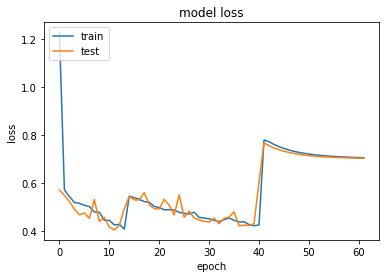

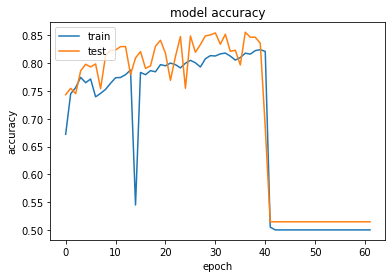

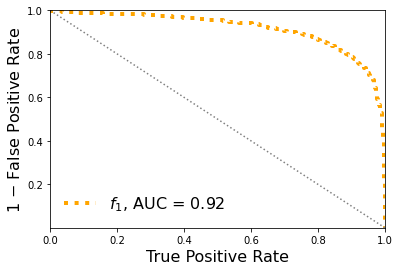

Classification score:


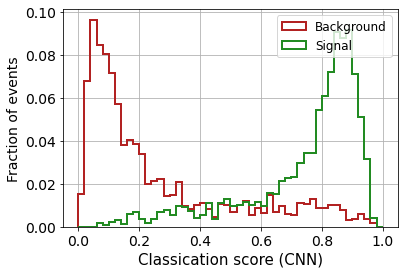


 ROC-AUC =  0.9158672465971558


In [48]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [49]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9158672465971558


## 2. only time diff

In [21]:
# concatenate the data

# all the background features
X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))

# all the signal features
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')



X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)



# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)



X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)



print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 1)
X_mon_S.shape:  (5000, 1)

X_mon5.shape:  (10000, 1)

X_mon5_train :  (4999, 1)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 1)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 1)
y_mon5_test :  (3334,)



In [22]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 35245)
y_mon_train :  (4999,)
X_mon_val :  (1667, 35245)
y_mon_val :  (1667,)
X_mon_test :  (3334, 35245)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68735	validation_1-logloss:0.68823
[1]	validation_0-logloss:0.68170	validation_1-logloss:0.68342
[2]	validation_0-logloss:0.67615	validation_1-logloss:0.67865
[3]	validation_0-logloss:0.67070	validation_1-logloss:0.67404
[4]	validation_0-logloss:0.66535	validation_1-logloss:0.66959
[5]	validation_0-logloss:0.66012	validation_1-logloss:0.66515
[6]	validation_0-logloss:0.65500	validation_1-logloss:0.66092
[7]	validation_0-logloss:0.64989	validation_1-logloss:0.65650
[8]	validation_0-logloss:0.64489	validation_1-logloss:0.65224
[9]	validation_0-logloss:0.63992	validation_1-logloss:0.64799
[10]	validation_0-logloss:0.63507	validation_1-logloss:0.64389
[11]	validation_0-logloss:0.63044	validation_1-logloss:0.63998
[12]	validation_0-logloss:0.62574	validation_1-logloss:0.63615
[13]	validation_0-logloss:0.62118	validation_1-logloss:0.63240
[14]	validation_0-logloss:0.61662	validation_1-logloss:0.62846
[15]	validation_0-logloss:0.61220	validation_1-logloss:0.62483
[1

[130]	validation_0-logloss:0.33208	validation_1-logloss:0.40891
[131]	validation_0-logloss:0.33081	validation_1-logloss:0.40809
[132]	validation_0-logloss:0.32941	validation_1-logloss:0.40725
[133]	validation_0-logloss:0.32799	validation_1-logloss:0.40626
[134]	validation_0-logloss:0.32667	validation_1-logloss:0.40540
[135]	validation_0-logloss:0.32534	validation_1-logloss:0.40440
[136]	validation_0-logloss:0.32397	validation_1-logloss:0.40342
[137]	validation_0-logloss:0.32256	validation_1-logloss:0.40251
[138]	validation_0-logloss:0.32121	validation_1-logloss:0.40155
[139]	validation_0-logloss:0.31985	validation_1-logloss:0.40066
[140]	validation_0-logloss:0.31859	validation_1-logloss:0.39986
[141]	validation_0-logloss:0.31734	validation_1-logloss:0.39912
[142]	validation_0-logloss:0.31610	validation_1-logloss:0.39822
[143]	validation_0-logloss:0.31477	validation_1-logloss:0.39730
[144]	validation_0-logloss:0.31346	validation_1-logloss:0.39649
[145]	validation_0-logloss:0.31219	valid

[259]	validation_0-logloss:0.20780	validation_1-logloss:0.32824
[260]	validation_0-logloss:0.20712	validation_1-logloss:0.32787
[261]	validation_0-logloss:0.20646	validation_1-logloss:0.32738
[262]	validation_0-logloss:0.20584	validation_1-logloss:0.32714
[263]	validation_0-logloss:0.20512	validation_1-logloss:0.32666
[264]	validation_0-logloss:0.20444	validation_1-logloss:0.32626
[265]	validation_0-logloss:0.20381	validation_1-logloss:0.32597
[266]	validation_0-logloss:0.20314	validation_1-logloss:0.32560
[267]	validation_0-logloss:0.20243	validation_1-logloss:0.32526
[268]	validation_0-logloss:0.20183	validation_1-logloss:0.32493
[269]	validation_0-logloss:0.20116	validation_1-logloss:0.32447
[270]	validation_0-logloss:0.20050	validation_1-logloss:0.32414
[271]	validation_0-logloss:0.19988	validation_1-logloss:0.32384
[272]	validation_0-logloss:0.19924	validation_1-logloss:0.32352
[273]	validation_0-logloss:0.19862	validation_1-logloss:0.32319
[274]	validation_0-logloss:0.19801	valid

[388]	validation_0-logloss:0.14300	validation_1-logloss:0.29222
[389]	validation_0-logloss:0.14270	validation_1-logloss:0.29210
[390]	validation_0-logloss:0.14234	validation_1-logloss:0.29189
[391]	validation_0-logloss:0.14190	validation_1-logloss:0.29172
[392]	validation_0-logloss:0.14156	validation_1-logloss:0.29152
[393]	validation_0-logloss:0.14120	validation_1-logloss:0.29134
[394]	validation_0-logloss:0.14081	validation_1-logloss:0.29110
[395]	validation_0-logloss:0.14048	validation_1-logloss:0.29087
[396]	validation_0-logloss:0.14012	validation_1-logloss:0.29071
[397]	validation_0-logloss:0.13983	validation_1-logloss:0.29061
[398]	validation_0-logloss:0.13954	validation_1-logloss:0.29041
[399]	validation_0-logloss:0.13912	validation_1-logloss:0.29009
[400]	validation_0-logloss:0.13875	validation_1-logloss:0.28981
[401]	validation_0-logloss:0.13847	validation_1-logloss:0.28964
[402]	validation_0-logloss:0.13811	validation_1-logloss:0.28951
[403]	validation_0-logloss:0.13768	valid

[517]	validation_0-logloss:0.10486	validation_1-logloss:0.27205
[518]	validation_0-logloss:0.10461	validation_1-logloss:0.27194
[519]	validation_0-logloss:0.10434	validation_1-logloss:0.27184
[520]	validation_0-logloss:0.10412	validation_1-logloss:0.27165
[521]	validation_0-logloss:0.10386	validation_1-logloss:0.27146
[522]	validation_0-logloss:0.10361	validation_1-logloss:0.27141
[523]	validation_0-logloss:0.10340	validation_1-logloss:0.27133
[524]	validation_0-logloss:0.10315	validation_1-logloss:0.27116
[525]	validation_0-logloss:0.10287	validation_1-logloss:0.27100
[526]	validation_0-logloss:0.10267	validation_1-logloss:0.27090
[527]	validation_0-logloss:0.10240	validation_1-logloss:0.27072
[528]	validation_0-logloss:0.10223	validation_1-logloss:0.27061
[529]	validation_0-logloss:0.10198	validation_1-logloss:0.27044
[530]	validation_0-logloss:0.10179	validation_1-logloss:0.27030
[531]	validation_0-logloss:0.10153	validation_1-logloss:0.27016
[532]	validation_0-logloss:0.10130	valid

[646]	validation_0-logloss:0.07879	validation_1-logloss:0.25868
[647]	validation_0-logloss:0.07865	validation_1-logloss:0.25860
[648]	validation_0-logloss:0.07844	validation_1-logloss:0.25854
[649]	validation_0-logloss:0.07825	validation_1-logloss:0.25844
[650]	validation_0-logloss:0.07808	validation_1-logloss:0.25833
[651]	validation_0-logloss:0.07793	validation_1-logloss:0.25829
[652]	validation_0-logloss:0.07778	validation_1-logloss:0.25825
[653]	validation_0-logloss:0.07759	validation_1-logloss:0.25813
[654]	validation_0-logloss:0.07745	validation_1-logloss:0.25811
[655]	validation_0-logloss:0.07729	validation_1-logloss:0.25799
[656]	validation_0-logloss:0.07720	validation_1-logloss:0.25792
[657]	validation_0-logloss:0.07701	validation_1-logloss:0.25784
[658]	validation_0-logloss:0.07686	validation_1-logloss:0.25775
[659]	validation_0-logloss:0.07667	validation_1-logloss:0.25772
[660]	validation_0-logloss:0.07648	validation_1-logloss:0.25766
[661]	validation_0-logloss:0.07630	valid

[775]	validation_0-logloss:0.06057	validation_1-logloss:0.25043
[776]	validation_0-logloss:0.06046	validation_1-logloss:0.25044
[777]	validation_0-logloss:0.06032	validation_1-logloss:0.25035
[778]	validation_0-logloss:0.06018	validation_1-logloss:0.25024
[779]	validation_0-logloss:0.06010	validation_1-logloss:0.25022
[780]	validation_0-logloss:0.05998	validation_1-logloss:0.25017
[781]	validation_0-logloss:0.05988	validation_1-logloss:0.25005
[782]	validation_0-logloss:0.05973	validation_1-logloss:0.25001
[783]	validation_0-logloss:0.05964	validation_1-logloss:0.24993
[784]	validation_0-logloss:0.05949	validation_1-logloss:0.24988
[785]	validation_0-logloss:0.05936	validation_1-logloss:0.24987
[786]	validation_0-logloss:0.05923	validation_1-logloss:0.24978
[787]	validation_0-logloss:0.05916	validation_1-logloss:0.24972
[788]	validation_0-logloss:0.05905	validation_1-logloss:0.24966
[789]	validation_0-logloss:0.05897	validation_1-logloss:0.24963
[790]	validation_0-logloss:0.05891	valid

[904]	validation_0-logloss:0.04833	validation_1-logloss:0.24549
[905]	validation_0-logloss:0.04823	validation_1-logloss:0.24543
[906]	validation_0-logloss:0.04811	validation_1-logloss:0.24540
[907]	validation_0-logloss:0.04805	validation_1-logloss:0.24537
[908]	validation_0-logloss:0.04798	validation_1-logloss:0.24533
[909]	validation_0-logloss:0.04790	validation_1-logloss:0.24527
[910]	validation_0-logloss:0.04783	validation_1-logloss:0.24519
[911]	validation_0-logloss:0.04773	validation_1-logloss:0.24517
[912]	validation_0-logloss:0.04766	validation_1-logloss:0.24509
[913]	validation_0-logloss:0.04760	validation_1-logloss:0.24499
[914]	validation_0-logloss:0.04749	validation_1-logloss:0.24493
[915]	validation_0-logloss:0.04742	validation_1-logloss:0.24492
[916]	validation_0-logloss:0.04734	validation_1-logloss:0.24489
[917]	validation_0-logloss:0.04726	validation_1-logloss:0.24484
[918]	validation_0-logloss:0.04720	validation_1-logloss:0.24475
[919]	validation_0-logloss:0.04708	valid

[1032]	validation_0-logloss:0.03942	validation_1-logloss:0.24129
[1033]	validation_0-logloss:0.03936	validation_1-logloss:0.24124
[1034]	validation_0-logloss:0.03929	validation_1-logloss:0.24119
[1035]	validation_0-logloss:0.03925	validation_1-logloss:0.24118
[1036]	validation_0-logloss:0.03916	validation_1-logloss:0.24115
[1037]	validation_0-logloss:0.03907	validation_1-logloss:0.24113
[1038]	validation_0-logloss:0.03901	validation_1-logloss:0.24111
[1039]	validation_0-logloss:0.03895	validation_1-logloss:0.24106
[1040]	validation_0-logloss:0.03889	validation_1-logloss:0.24097
[1041]	validation_0-logloss:0.03883	validation_1-logloss:0.24092
[1042]	validation_0-logloss:0.03880	validation_1-logloss:0.24092
[1043]	validation_0-logloss:0.03874	validation_1-logloss:0.24089
[1044]	validation_0-logloss:0.03869	validation_1-logloss:0.24086
[1045]	validation_0-logloss:0.03863	validation_1-logloss:0.24080
[1046]	validation_0-logloss:0.03858	validation_1-logloss:0.24081
[1047]	validation_0-loglo

[1159]	validation_0-logloss:0.03234	validation_1-logloss:0.23948
[1160]	validation_0-logloss:0.03228	validation_1-logloss:0.23948
[1161]	validation_0-logloss:0.03225	validation_1-logloss:0.23946
[1162]	validation_0-logloss:0.03223	validation_1-logloss:0.23947
[1163]	validation_0-logloss:0.03217	validation_1-logloss:0.23947
[1164]	validation_0-logloss:0.03214	validation_1-logloss:0.23946
[1165]	validation_0-logloss:0.03210	validation_1-logloss:0.23949
[1166]	validation_0-logloss:0.03203	validation_1-logloss:0.23953
[1167]	validation_0-logloss:0.03199	validation_1-logloss:0.23949
[1168]	validation_0-logloss:0.03196	validation_1-logloss:0.23948
[1169]	validation_0-logloss:0.03188	validation_1-logloss:0.23954
[1170]	validation_0-logloss:0.03184	validation_1-logloss:0.23954
[1171]	validation_0-logloss:0.03179	validation_1-logloss:0.23951
[1172]	validation_0-logloss:0.03173	validation_1-logloss:0.23947
[1173]	validation_0-logloss:0.03169	validation_1-logloss:0.23943
[1174]	validation_0-loglo

[1286]	validation_0-logloss:0.02657	validation_1-logloss:0.23862
[1287]	validation_0-logloss:0.02655	validation_1-logloss:0.23862
[1288]	validation_0-logloss:0.02650	validation_1-logloss:0.23859
[1289]	validation_0-logloss:0.02646	validation_1-logloss:0.23856
[1290]	validation_0-logloss:0.02642	validation_1-logloss:0.23853
[1291]	validation_0-logloss:0.02636	validation_1-logloss:0.23853
[1292]	validation_0-logloss:0.02631	validation_1-logloss:0.23856
[1293]	validation_0-logloss:0.02627	validation_1-logloss:0.23855
[1294]	validation_0-logloss:0.02624	validation_1-logloss:0.23855
[1295]	validation_0-logloss:0.02618	validation_1-logloss:0.23858
[1296]	validation_0-logloss:0.02617	validation_1-logloss:0.23857
[1297]	validation_0-logloss:0.02612	validation_1-logloss:0.23858
[1298]	validation_0-logloss:0.02609	validation_1-logloss:0.23853
[1299]	validation_0-logloss:0.02606	validation_1-logloss:0.23852
[1300]	validation_0-logloss:0.02602	validation_1-logloss:0.23853
[1301]	validation_0-loglo

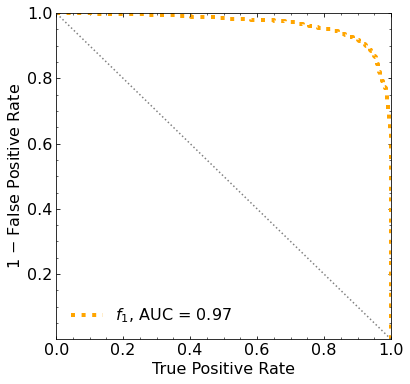

Classification score:


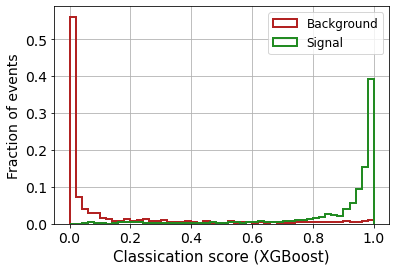


 ROC-AUC =  0.9674163434432437


In [23]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [24]:
np.savetxt('rocs/roc_arraysdt.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9674163434432437


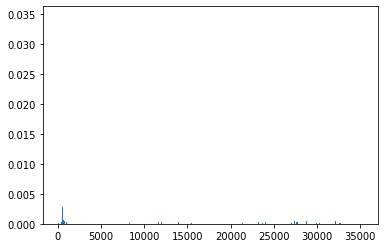

In [25]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

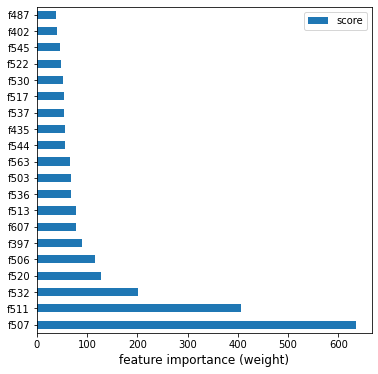


f35245: pdiffT


In [26]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()



print('\nf'+ str(len(classifier.feature_importances_)) + ': pdiffT')

### DNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               9022976   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

40/40 [==============================] - 1s 36ms/step - loss: 0.3209 - accuracy: 0.8691 - val_loss: 0.2948 - val_accuracy: 0.8806
Epoch 93/500
40/40 [==============================] - 1s 37ms/step - loss: 0.3078 - accuracy: 0.8787 - val_loss: 0.3140 - val_accuracy: 0.8800
Epoch 94/500
40/40 [==============================] - 1s 35ms/step - loss: 0.3171 - accuracy: 0.8747 - val_loss: 0.3163 - val_accuracy: 0.8686
Epoch 95/500
40/40 [==============================] - 1s 36ms/step - loss: 0.3056 - accuracy: 0.8808 - val_loss: 0.2903 - val_accuracy: 0.8800
Epoch 96/500
40/40 [==============================] - 1s 36ms/step - loss: 0.2942 - accuracy: 0.8915 - val_loss: 0.3071 - val_accuracy: 0.8740
Epoch 97/500
40/40 [==============================] - 1s 36ms/step - loss: 0.2963 - accuracy: 0.8899 - val_loss: 0.3083 - val_accuracy: 0.8662
Epoch 98/500
40/40 [==============================] - 1s 35ms/step - loss: 0.3208 - accuracy: 0.8695 - val_loss: 0.3144 - val_accuracy: 0.8782
Epoch 99/500

40/40 [==============================] - 1s 34ms/step - loss: 0.2476 - accuracy: 0.9089 - val_loss: 0.2999 - val_accuracy: 0.8902
Epoch 150/500
40/40 [==============================] - 1s 36ms/step - loss: 0.2389 - accuracy: 0.9120 - val_loss: 0.2965 - val_accuracy: 0.8782
Epoch 151/500
40/40 [==============================] - 1s 35ms/step - loss: 0.2528 - accuracy: 0.8962 - val_loss: 0.2827 - val_accuracy: 0.8938
Epoch 152/500
40/40 [==============================] - 1s 35ms/step - loss: 0.2326 - accuracy: 0.9171 - val_loss: 0.2813 - val_accuracy: 0.8872
Epoch 153/500
40/40 [==============================] - 1s 36ms/step - loss: 0.2533 - accuracy: 0.9038 - val_loss: 0.3155 - val_accuracy: 0.8902
Epoch 154/500
40/40 [==============================] - 1s 35ms/step - loss: 0.2553 - accuracy: 0.9002 - val_loss: 0.3626 - val_accuracy: 0.8404
Epoch 155/500
40/40 [==============================] - 1s 35ms/step - loss: 0.2696 - accuracy: 0.8944 - val_loss: 0.3651 - val_accuracy: 0.8644
Epoch 

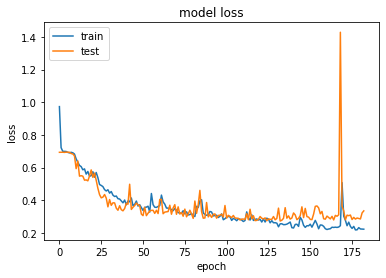

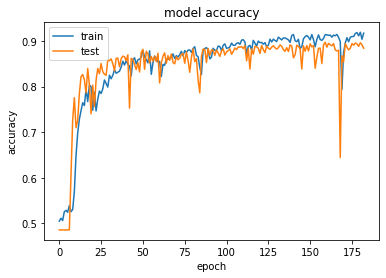

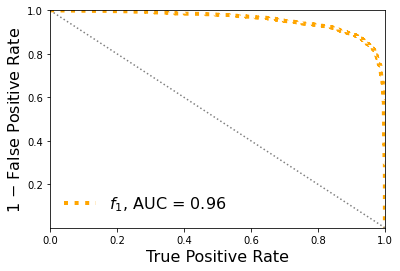

Classification score:


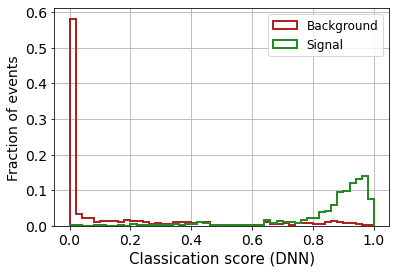


 ROC-AUC =  0.9569927479893919


In [27]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [28]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9569927479893919


### CNN

In [ ]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

## 3. All compressed features

In [25]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 17)
X_mon_S.shape:  (5000, 17)

X_mon5.shape:  (10000, 17)

X_mon5_train :  (4999, 17)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 17)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 17)
y_mon5_test :  (3334,)



##### Concatenate into one single big dataset

In [26]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val


In [27]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 35261)
y_mon_train :  (4999,)
X_mon_val :  (1667, 35261)
y_mon_val :  (1667,)
X_mon_test :  (3334, 35261)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68637	validation_1-logloss:0.68702
[1]	validation_0-logloss:0.67967	validation_1-logloss:0.68102
[2]	validation_0-logloss:0.67315	validation_1-logloss:0.67517
[3]	validation_0-logloss:0.66672	validation_1-logloss:0.66944
[4]	validation_0-logloss:0.66044	validation_1-logloss:0.66383
[5]	validation_0-logloss:0.65428	validation_1-logloss:0.65833
[6]	validation_0-logloss:0.64823	validation_1-logloss:0.65292
[7]	validation_0-logloss:0.64226	validation_1-logloss:0.64759
[8]	validation_0-logloss:0.63639	validation_1-logloss:0.64238
[9]	validation_0-logloss:0.63064	validation_1-logloss:0.63725
[10]	validation_0-logloss:0.62501	validation_1-logloss:0.63222
[11]	validation_0-logloss:0.61945	validation_1-logloss:0.62725
[12]	validation_0-logloss:0.61391	validation_1-logloss:0.62218
[13]	validation_0-logloss:0.60856	validation_1-logloss:0.61751
[14]	validation_0-logloss:0.60327	validation_1-logloss:0.61283
[15]	validation_0-logloss:0.59797	validation_1-logloss:0.60803
[1

[130]	validation_0-logloss:0.28591	validation_1-logloss:0.34196
[131]	validation_0-logloss:0.28452	validation_1-logloss:0.34093
[132]	validation_0-logloss:0.28318	validation_1-logloss:0.33990
[133]	validation_0-logloss:0.28181	validation_1-logloss:0.33890
[134]	validation_0-logloss:0.28031	validation_1-logloss:0.33774
[135]	validation_0-logloss:0.27901	validation_1-logloss:0.33664
[136]	validation_0-logloss:0.27773	validation_1-logloss:0.33553
[137]	validation_0-logloss:0.27642	validation_1-logloss:0.33456
[138]	validation_0-logloss:0.27514	validation_1-logloss:0.33357
[139]	validation_0-logloss:0.27388	validation_1-logloss:0.33255
[140]	validation_0-logloss:0.27264	validation_1-logloss:0.33157
[141]	validation_0-logloss:0.27137	validation_1-logloss:0.33064
[142]	validation_0-logloss:0.27017	validation_1-logloss:0.32969
[143]	validation_0-logloss:0.26895	validation_1-logloss:0.32872
[144]	validation_0-logloss:0.26779	validation_1-logloss:0.32785
[145]	validation_0-logloss:0.26656	valid

[259]	validation_0-logloss:0.17198	validation_1-logloss:0.26168
[260]	validation_0-logloss:0.17143	validation_1-logloss:0.26132
[261]	validation_0-logloss:0.17086	validation_1-logloss:0.26095
[262]	validation_0-logloss:0.17031	validation_1-logloss:0.26067
[263]	validation_0-logloss:0.16986	validation_1-logloss:0.26044
[264]	validation_0-logloss:0.16931	validation_1-logloss:0.26000
[265]	validation_0-logloss:0.16879	validation_1-logloss:0.25975
[266]	validation_0-logloss:0.16822	validation_1-logloss:0.25943
[267]	validation_0-logloss:0.16770	validation_1-logloss:0.25921
[268]	validation_0-logloss:0.16727	validation_1-logloss:0.25899
[269]	validation_0-logloss:0.16671	validation_1-logloss:0.25872
[270]	validation_0-logloss:0.16618	validation_1-logloss:0.25838
[271]	validation_0-logloss:0.16565	validation_1-logloss:0.25806
[272]	validation_0-logloss:0.16515	validation_1-logloss:0.25781
[273]	validation_0-logloss:0.16461	validation_1-logloss:0.25752
[274]	validation_0-logloss:0.16412	valid

[388]	validation_0-logloss:0.12101	validation_1-logloss:0.23841
[389]	validation_0-logloss:0.12067	validation_1-logloss:0.23839
[390]	validation_0-logloss:0.12032	validation_1-logloss:0.23836
[391]	validation_0-logloss:0.12009	validation_1-logloss:0.23827
[392]	validation_0-logloss:0.11979	validation_1-logloss:0.23816
[393]	validation_0-logloss:0.11955	validation_1-logloss:0.23806
[394]	validation_0-logloss:0.11924	validation_1-logloss:0.23780
[395]	validation_0-logloss:0.11901	validation_1-logloss:0.23771
[396]	validation_0-logloss:0.11872	validation_1-logloss:0.23765
[397]	validation_0-logloss:0.11847	validation_1-logloss:0.23755
[398]	validation_0-logloss:0.11819	validation_1-logloss:0.23746
[399]	validation_0-logloss:0.11790	validation_1-logloss:0.23734
[400]	validation_0-logloss:0.11766	validation_1-logloss:0.23724
[401]	validation_0-logloss:0.11731	validation_1-logloss:0.23715
[402]	validation_0-logloss:0.11710	validation_1-logloss:0.23707
[403]	validation_0-logloss:0.11688	valid

[517]	validation_0-logloss:0.09201	validation_1-logloss:0.23059
[518]	validation_0-logloss:0.09179	validation_1-logloss:0.23058
[519]	validation_0-logloss:0.09168	validation_1-logloss:0.23051
[520]	validation_0-logloss:0.09146	validation_1-logloss:0.23045
[521]	validation_0-logloss:0.09130	validation_1-logloss:0.23035
[522]	validation_0-logloss:0.09113	validation_1-logloss:0.23035
[523]	validation_0-logloss:0.09092	validation_1-logloss:0.23029
[524]	validation_0-logloss:0.09071	validation_1-logloss:0.23023
[525]	validation_0-logloss:0.09055	validation_1-logloss:0.23017
[526]	validation_0-logloss:0.09044	validation_1-logloss:0.23013
[527]	validation_0-logloss:0.09030	validation_1-logloss:0.23013
[528]	validation_0-logloss:0.09014	validation_1-logloss:0.23002
[529]	validation_0-logloss:0.08998	validation_1-logloss:0.23002
[530]	validation_0-logloss:0.08976	validation_1-logloss:0.22997
[531]	validation_0-logloss:0.08965	validation_1-logloss:0.22990
[532]	validation_0-logloss:0.08942	valid

[646]	validation_0-logloss:0.07225	validation_1-logloss:0.22495
[647]	validation_0-logloss:0.07208	validation_1-logloss:0.22489
[648]	validation_0-logloss:0.07200	validation_1-logloss:0.22484
[649]	validation_0-logloss:0.07193	validation_1-logloss:0.22487
[650]	validation_0-logloss:0.07176	validation_1-logloss:0.22485
[651]	validation_0-logloss:0.07161	validation_1-logloss:0.22488
[652]	validation_0-logloss:0.07143	validation_1-logloss:0.22482
[653]	validation_0-logloss:0.07129	validation_1-logloss:0.22479
[654]	validation_0-logloss:0.07117	validation_1-logloss:0.22477
[655]	validation_0-logloss:0.07105	validation_1-logloss:0.22478
[656]	validation_0-logloss:0.07094	validation_1-logloss:0.22471
[657]	validation_0-logloss:0.07079	validation_1-logloss:0.22473
[658]	validation_0-logloss:0.07064	validation_1-logloss:0.22468
[659]	validation_0-logloss:0.07055	validation_1-logloss:0.22465
[660]	validation_0-logloss:0.07039	validation_1-logloss:0.22454
[661]	validation_0-logloss:0.07023	valid

[775]	validation_0-logloss:0.05794	validation_1-logloss:0.22182
[776]	validation_0-logloss:0.05786	validation_1-logloss:0.22182
[777]	validation_0-logloss:0.05775	validation_1-logloss:0.22185
[778]	validation_0-logloss:0.05763	validation_1-logloss:0.22183
[779]	validation_0-logloss:0.05756	validation_1-logloss:0.22187
[780]	validation_0-logloss:0.05742	validation_1-logloss:0.22183
[781]	validation_0-logloss:0.05736	validation_1-logloss:0.22182
[782]	validation_0-logloss:0.05728	validation_1-logloss:0.22177
[783]	validation_0-logloss:0.05719	validation_1-logloss:0.22173
[784]	validation_0-logloss:0.05710	validation_1-logloss:0.22176
[785]	validation_0-logloss:0.05702	validation_1-logloss:0.22176
[786]	validation_0-logloss:0.05696	validation_1-logloss:0.22177
[787]	validation_0-logloss:0.05685	validation_1-logloss:0.22175
[788]	validation_0-logloss:0.05674	validation_1-logloss:0.22177
[789]	validation_0-logloss:0.05665	validation_1-logloss:0.22172
[790]	validation_0-logloss:0.05659	valid

[904]	validation_0-logloss:0.04722	validation_1-logloss:0.22132
[905]	validation_0-logloss:0.04716	validation_1-logloss:0.22129
[906]	validation_0-logloss:0.04711	validation_1-logloss:0.22126
[907]	validation_0-logloss:0.04701	validation_1-logloss:0.22127
[908]	validation_0-logloss:0.04695	validation_1-logloss:0.22129
[909]	validation_0-logloss:0.04689	validation_1-logloss:0.22129
[910]	validation_0-logloss:0.04684	validation_1-logloss:0.22128
[911]	validation_0-logloss:0.04675	validation_1-logloss:0.22129
[912]	validation_0-logloss:0.04669	validation_1-logloss:0.22129
[913]	validation_0-logloss:0.04663	validation_1-logloss:0.22133
[914]	validation_0-logloss:0.04658	validation_1-logloss:0.22132
[915]	validation_0-logloss:0.04652	validation_1-logloss:0.22131
[916]	validation_0-logloss:0.04642	validation_1-logloss:0.22129
[917]	validation_0-logloss:0.04633	validation_1-logloss:0.22133
[918]	validation_0-logloss:0.04624	validation_1-logloss:0.22133
[919]	validation_0-logloss:0.04615	valid

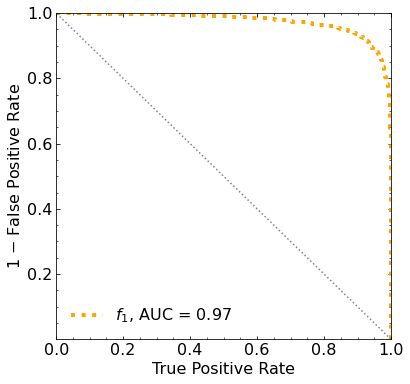

Classification score:


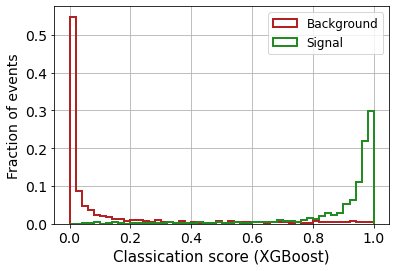


 ROC-AUC =  0.9743321728964562


In [28]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [29]:
np.savetxt('rocs/roc_arrays17feats.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9743321728964562


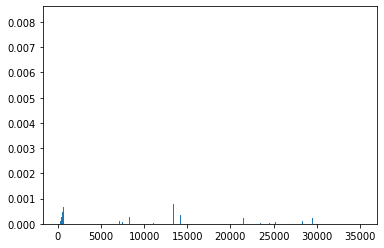

In [34]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

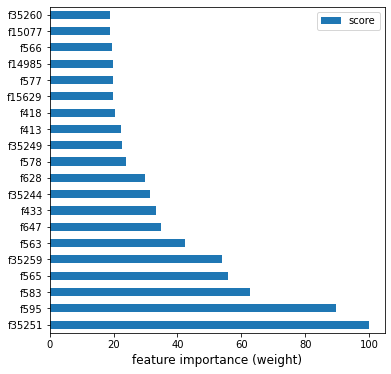


peakS1:     147 features  --> f0 to f146
peakS2:    2298 features  --> f147 to f2444
hits bot: 16384 features  --> f2445 to f18828
hits top: 16384 features  --> f18829 to f35212
resumed:     17 features  --> f35213 to f35229

f35213: pA_S1 
f35214: pH_S1 
f35215: pHT_S1 
f35216: pL_S1 
f35217: pL90_S1 
f35218: pRMSW_S1 
f35219: pHTL_S1 
f35220: pA_S2 
f35221: pH_S2 
f35222: pHT_S2 
f35223: pL_S2 
f35224: pL90_S2 
f35225: pRMSW_S2 
f35226: pHTL_S2 
f35227: pbot 
f35228: ptop 
f35229: pdiffT


In [35]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

print('\npeakS1:     147 features  --> f0 to f146')
print('peakS2:    2298 features  --> f147 to f2444')
print('hits bot: 16384 features  --> f2445 to f18828')
print('hits top: 16384 features  --> f18829 to f35212')
print('resumed:     17 features  --> f35213 to f35229')

print('\nf35213: pA_S1',
      '\nf35214: pH_S1',
      '\nf35215: pHT_S1',
      '\nf35216: pL_S1',
      '\nf35217: pL90_S1',
      '\nf35218: pRMSW_S1',
      '\nf35219: pHTL_S1',
      '\nf35220: pA_S2',
      '\nf35221: pH_S2',
      '\nf35222: pHT_S2',
      '\nf35223: pL_S2',
      '\nf35224: pL90_S2',
      '\nf35225: pRMSW_S2',
      '\nf35226: pHTL_S2',
      '\nf35227: pbot', 
      '\nf35228: ptop',
      '\nf35229: pdiffT')

In [36]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  14
range of our data:  [[0, 1]]


In [37]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0205


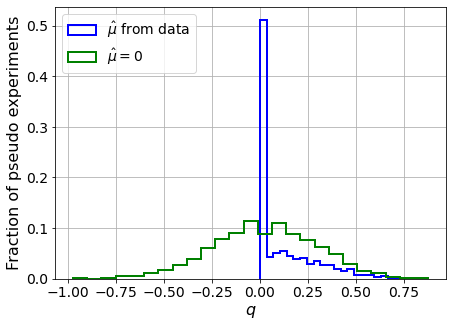

muhat mean:  0.11999672588497666
Z_bins:  0.17102903301636463
std Z_bins:  0.48915020543662724
Z_bins mu=0:  0.170943307034524
std Z_bins mu=0:  0.8145492802086818

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0255


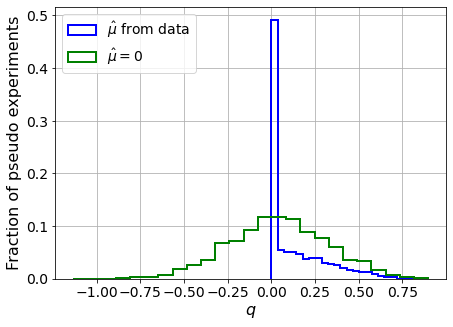

muhat mean:  -0.12159973201326907
Z_bins:  0.20605063434340393
std Z_bins:  0.428361168390086
Z_bins mu=0:  0.20605063434340393
std Z_bins mu=0:  0.6891380403860285

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.022


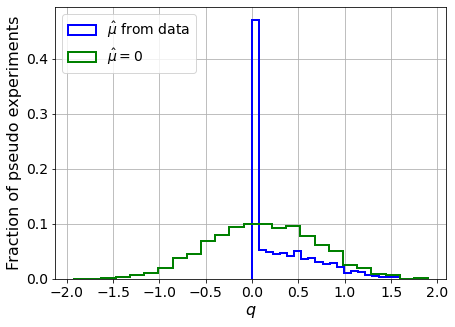

muhat mean:  0.012994405353878554
Z_bins:  0.3432851468645185
std Z_bins:  0.5393397870178099
Z_bins mu=0:  0.34314738143167145
std Z_bins mu=0:  0.8303288099531401

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.02


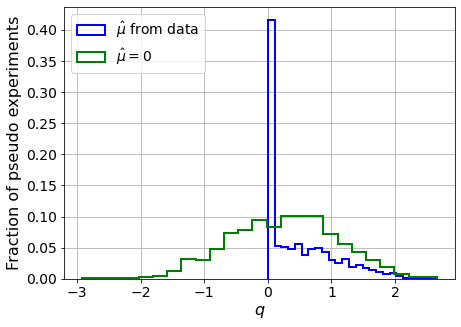

muhat mean:  0.044513825989880934
Z_bins:  0.5237364092208784
std Z_bins:  0.5325695079225555
Z_bins mu=0:  0.5236075411580775
std Z_bins mu=0:  0.805738435069253

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.019


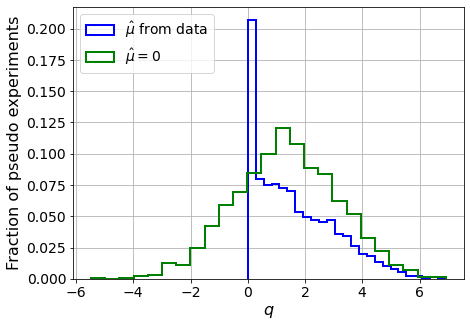

muhat mean:  -0.00031857637387420497
Z_bins:  1.158131145508106
std Z_bins:  0.6076551660692437
Z_bins mu=0:  1.158061698344885
std Z_bins mu=0:  0.7788670698486891

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.022


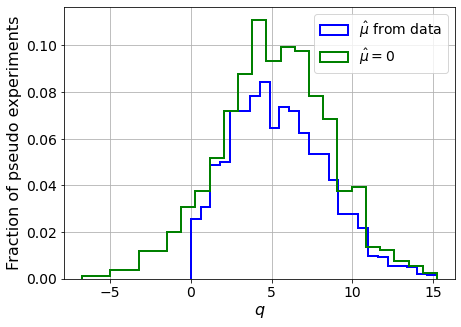

muhat mean:  0.01103615932605672
Z_bins:  2.2816538112460987
std Z_bins:  0.6450990013858846
Z_bins mu=0:  2.281530688343431
std Z_bins mu=0:  0.7540053271862113

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.023


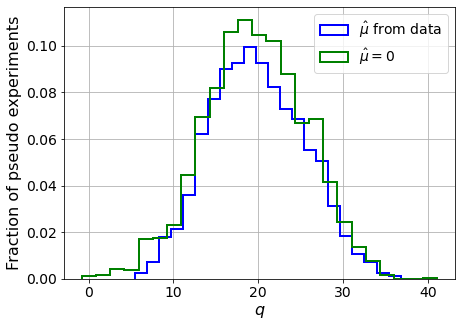

muhat mean:  -0.0040480642004764224
Z_bins:  4.4286963207664325
std Z_bins:  0.6224058623265409
Z_bins mu=0:  4.427890039446477
std Z_bins mu=0:  0.6704869470886631

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0215


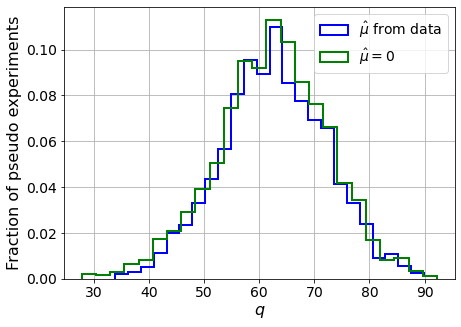

muhat mean:  0.0017446644532664206
Z_bins:  7.919697731040711
std Z_bins:  0.6023182207587253
Z_bins mu=0:  7.919697731040711
std Z_bins mu=0:  0.6363239529170321

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.021


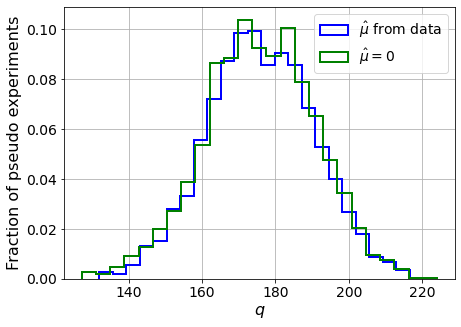

muhat mean:  -0.0003075298500259021
Z_bins:  13.256975196789234
std Z_bins:  0.5480702857316516
Z_bins mu=0:  13.254426099050132
std Z_bins mu=0:  0.565474976025268

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0185


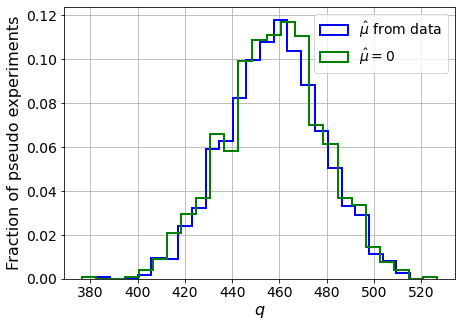

muhat mean:  -0.00031610481721957895
Z_bins:  21.405174590831006
std Z_bins:  0.4789462591899402
Z_bins mu=0:  21.40499560751569
std Z_bins mu=0:  0.4894473779306984

--------


 FINAL RESULT:

[[0.17102903301636463, 0.48915020543662724, 0.11999672588497666, 0.170943307034524, 0.8145492802086818], [0.20605063434340393, 0.428361168390086, -0.12159973201326907, 0.20605063434340393, 0.6891380403860285], [0.3432851468645185, 0.5393397870178099, 0.012994405353878554, 0.34314738143167145, 0.8303288099531401], [0.5237364092208784, 0.5325695079225555, 0.044513825989880934, 0.5236075411580775, 0.805738435069253], [1.158131145508106, 0.6076551660692437, -0.00031857637387420497, 1.158061698344885, 0.7788670698486891], [2.2816538112460987, 0.6450990013858846, 0.01103615932605672, 2.281530688343431, 0.7540053271862113], [4.4286963207664325, 0.6224058623265409, -0.0040480642004764224, 4.427890039446477, 0.6704869470886631], [7.919697731040711, 0.6023182207587253, 0.0017446644532664206, 7.91969773104

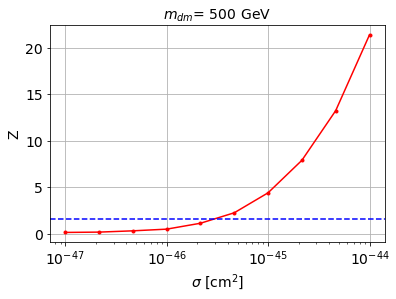


cross_BL_164:  2.9943118438657613e-46
cross_BL_164_up:  1.880336068998916e-46
cross_BL_164_down:  4.6472490383229285e-46


In [38]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               9027072   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

40/40 [==============================] - 1s 33ms/step - loss: 0.2119 - accuracy: 0.9224 - val_loss: 0.2836 - val_accuracy: 0.8884
Epoch 93/500
40/40 [==============================] - 1s 33ms/step - loss: 0.2355 - accuracy: 0.9075 - val_loss: 0.2582 - val_accuracy: 0.8992
Epoch 94/500
40/40 [==============================] - 1s 33ms/step - loss: 0.3020 - accuracy: 0.8934 - val_loss: 0.2340 - val_accuracy: 0.9124
Epoch 95/500
40/40 [==============================] - 1s 32ms/step - loss: 0.2400 - accuracy: 0.9114 - val_loss: 0.2447 - val_accuracy: 0.9100
Epoch 96/500
40/40 [==============================] - 1s 32ms/step - loss: 0.2455 - accuracy: 0.9087 - val_loss: 0.2450 - val_accuracy: 0.9106
Epoch 97/500
40/40 [==============================] - 1s 33ms/step - loss: 0.2526 - accuracy: 0.9018 - val_loss: 0.2883 - val_accuracy: 0.8782
Epoch 98/500
40/40 [==============================] - 1s 32ms/step - loss: 0.2523 - accuracy: 0.9072 - val_loss: 0.2623 - val_accuracy: 0.8956
Epoch 99/500

40/40 [==============================] - 1s 33ms/step - loss: 0.1876 - accuracy: 0.9258 - val_loss: 0.2310 - val_accuracy: 0.9148
Epoch 150/500
40/40 [==============================] - 1s 34ms/step - loss: 0.1951 - accuracy: 0.9307 - val_loss: 0.2734 - val_accuracy: 0.8932
Epoch 151/500
40/40 [==============================] - 1s 34ms/step - loss: 0.1826 - accuracy: 0.9259 - val_loss: 0.2473 - val_accuracy: 0.9142
Epoch 152/500
40/40 [==============================] - 1s 33ms/step - loss: 0.1667 - accuracy: 0.9416 - val_loss: 0.2768 - val_accuracy: 0.8992
Epoch 153/500
40/40 [==============================] - 1s 33ms/step - loss: 0.1969 - accuracy: 0.9271 - val_loss: 0.2455 - val_accuracy: 0.9106
Epoch 154/500
40/40 [==============================] - 1s 34ms/step - loss: 0.1838 - accuracy: 0.9326 - val_loss: 0.2314 - val_accuracy: 0.9160
Epoch 155/500
40/40 [==============================] - 1s 33ms/step - loss: 0.1817 - accuracy: 0.9413 - val_loss: 0.2441 - val_accuracy: 0.9160
Epoch 

Epoch 206/500
40/40 [==============================] - 1s 33ms/step - loss: 0.2158 - accuracy: 0.9160 - val_loss: 0.2405 - val_accuracy: 0.9022
Epoch 207/500
40/40 [==============================] - 1s 34ms/step - loss: 0.1798 - accuracy: 0.9287 - val_loss: 0.2265 - val_accuracy: 0.9154
Epoch 208/500
40/40 [==============================] - 1s 32ms/step - loss: 0.1835 - accuracy: 0.9299 - val_loss: 0.2290 - val_accuracy: 0.9172
Epoch 209/500
40/40 [==============================] - 1s 34ms/step - loss: 0.1756 - accuracy: 0.9346 - val_loss: 0.2516 - val_accuracy: 0.9082
Epoch 210/500
40/40 [==============================] - 1s 35ms/step - loss: 0.1658 - accuracy: 0.9366 - val_loss: 0.2869 - val_accuracy: 0.8968
Epoch 211/500
40/40 [==============================] - 1s 34ms/step - loss: 0.2031 - accuracy: 0.9111 - val_loss: 0.2658 - val_accuracy: 0.9010
Epoch 212/500
40/40 [==============================] - 1s 34ms/step - loss: 0.1963 - accuracy: 0.9280 - val_loss: 0.2430 - val_accuracy:

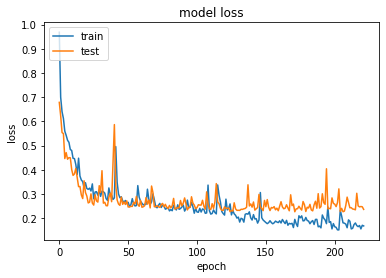

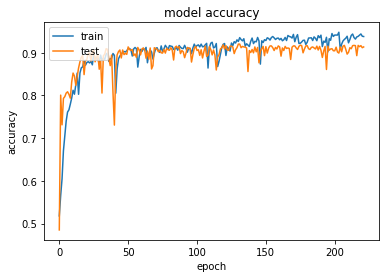

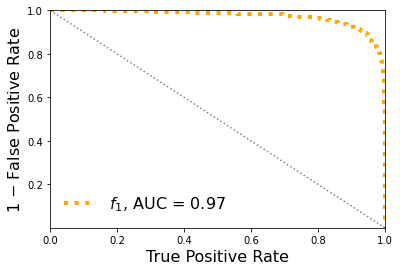

Classification score:


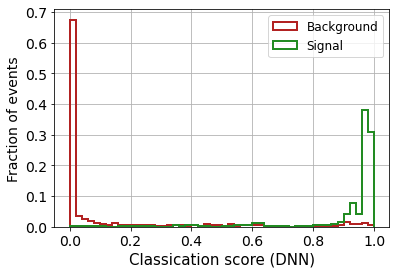


 ROC-AUC =  0.9724853361667574


In [39]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [40]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9724853361667574


### CNN

In [41]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

In [ ]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)